In [3]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from tqdm.notebook import tqdm
# from scipy.signal import welch
from matplotlib import colors
from scipy import stats
from scipy.optimize import curve_fit
import h5py

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from qick.rfboard import RFQickSocV2
soc = RFQickSocV2('qick_111_rfbrd_v2.bit')
# Load bitstream with custom overlay
# soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")

soccfg = soc
print(soccfg)

resetting clocks: 204.8

QICK configuration:

	Board: ZCU111

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 0, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	1:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 0, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	2:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 0, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	3:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 1, ch 0, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	4:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 1, ch 1, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	5:	axis_signal_gen_v6 - tProc output 6, envelope memory 65536 samples
		DAC tile 1, ch 2, 32-bit DDS, fabric=384.000 MHz, fs=6144.000 MHz
	6:	axis_s

### SET UP CONFIGURATION

In [5]:
def plot_decimated(iq_list, soccfg, config, plot_iq=True):
#     fig, axs = plt.subplots(2,1,figsize=(10,10))
    t = soccfg.cycles2us(np.arange(len(iq_list[0][0])), ro_ch=config['ro_ch'])

    for ii, iq in enumerate(iq_list):
#         plot = axs[ii]
        if plot_iq:
            plt.plot(t, iq[0], label="I value, ADC %d"%(config['ro_ch']))
            plt.plot(t, iq[1], label="Q value, ADC %d"%(config['ro_ch']))
            plt.plot(t, np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_ch']))
        else:
            plt.plot(t, iq[0], label="input value, ADC %d"%(config['ro_ch']))
        plt.ylabel("a.u.")
        plt.xlabel("Time [us]")
        plt.title("Averages = " + str(config["soft_avgs"]))
        plt.legend()

In [6]:
def noise(d_buf, verbose=True):
    diq = d_buf[:,0]+1j*d_buf[:,1]
    dmean = np.mean(diq)
    dmag = np.abs(dmean)
    if verbose: print("mean signal is %s (amplitude %f)" % (str(dmean), dmag))
    drotated = diq*np.exp(-1j*np.angle(dmean))
    magerr = np.real(drotated) # noise in the radial direction
    phaerr = np.imag(drotated) # noise in the radial direction
    
    rmsmag = np.std(magerr) # noise in the radial direction
    rmspha = np.std(phaerr) # noise in the azimuth direction
#     plt.hist(np.real(drotated))
    if verbose:
        print("amplitude noise: %f ADU, %f as a fraction of the signal (%f dB)" % (rmsmag, rmsmag/dmag, 20*np.log10(rmsmag/dmag)))
        print("phase noise: %f ADU, %f radians" % (rmspha, rmspha/dmag))
    return dmag, rmsmag, rmspha, magerr, phaerr

In [7]:
def plot_accumulated(iq_list, d_buf, prog, config, span=100):
    iq = np.array(iq_list)[:,0,0]
    
    hrange = [[iq[0]-span, iq[0]+span],[iq[1]-span, iq[1]+span]]
    plt.hist2d(d_buf[:,0], d_buf[:,1], bins=100, range=hrange, norm=colors.LogNorm())
    
    plt.xlabel("I value")
    plt.ylabel("Q value")

In [6]:
# various considerations, not all mutually compatible:

# LO performance is best if you use an integer multiple of the reference clock (122.88 MHz)
# LO freqs <7.5 GHz are generated using a divider, so you will see some of the original VCO freq (some multiple of the LO)
# the mixers allow a fair bit of LO leakage, and there also seems to be some crosstalk between LOs
# so you get a cleaner spectrum if you use a single LO
# second best: use LOs that are simple multiples of each other

# the low-pass filter we use on both ADC and DAC IF (LFCN-1800D) is ~2.1 GHz
# the ADC Nyquist freq is ~1.5 GHz, so IFs above ~900 MHz see up to 3 dB more (2x) noise power
# this assumes the noise spectrum is broadband and white
# and it may not be the limiting factor in your measurement
# a well-chosen external filter will help

# on the DAC side, the max IF is just set by the low-pass
# anything up to 1.8 GHz (rated band of the filter) should be OK

# we're using double-sideband mixers, so you will always see both LO+IF and LO-IF, only one of which is desired
# for your qubit drive, this means dumping a lot of power at some random freq - might be harmless?
# for readout, the spur is also going to get mixed back down to your IF
# this would basically mean you have a second readout path that is always off-resonance
# the RF outputs are low-passed at ~7 GHz (LFCW-6000), so it's nice if you can set your LO high enough that only LO-IF is passed
# or of course you can add an external filter

# it does not seem possible to saturate the DAC chain
# the ADC chain (probably the input amplifier) is always what saturates

# caution! you can get in a situation where the ADC gets saturated by LO leakage
# the usual case is low pulse gain, low DAC attenuation, LO not well filtered out, low external attenuation
# in this case the DAC gain sweep will still look linear, though you may see phase shifts
# but you will not get the expected response to small changes in attenuation
# e.g. increasing the second DAC attenuator may actually increase the system gain
# similar concerns about LO leakage power probably apply to the cold electronics

In [8]:
hw_cfg={"res_ch":5,
        "ro_ch":0,
#         "f_res":6000
        "f_res":6558.2 # AQT
#         "f_res":5828.5 # NEXUS
       }

rfb_cfg={
#         "f_lo_ro":122.88*60, # 7372.8 - better SNR
        "f_lo_ro":122.88*65, # 7987.20 - less LO leakage
#          "f_lo_qubit":122.88*28,
        "att_res":(0,10),
#         "att_qubit":(0,16),
         "att_ro":30
       }
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0, verbose=True) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
# soc.rfb_set_gen_rf(gen_ch=hw_cfg['qubit_ch'], att1=rfb_cfg['att_qubit'][0], att2=rfb_cfg['att_qubit'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

meas_cfg={"pulse_gain":10000,
    "if_res": abs(soc.rfb_get_lo(gen_ch=hw_cfg['res_ch']) - hw_cfg['f_res']), # MHz, start value
#     "if_ge": abs(soc.rfb_get_lo(gen_ch=hw_cfg['qubit_ch']) - hw_cfg['f_ge']), # MHz, start value
    "nqz":1,
    'adc_trig_offset': 0.42,
    'length': 10,
    'readout_padding': -0.1,
    'relax_delay': 1
       }

# print("qubit IF=%f, readout IF=%f"%(meas_cfg['if_ge'], meas_cfg['if_res']))
print("readout IF=%f"%(meas_cfg['if_res']))

  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 |  7987.20 |   1 |       1 |   65 |  False |    1 |    1 |     1 |  122.88 |  7987.20 |    0.00 | 6.5000e+01

Choosing solution 0 with minimal metric 65.
LO locked on attempt 1 after 0.02 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 |  7987.20 |   1 |       1 |   65 |  False |    1 |    1 |     1 |  122.88 |  7987.20 |    0.00 | 6.5000e+01

Choosing solution 0 with minimal metric 65.
LO locked on attempt 1 after 0.02 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------

  0%|          | 0/1 [00:00<?, ?it/s]

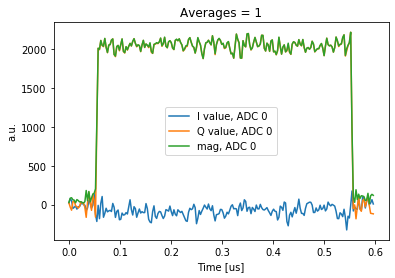

In [9]:
class SingleGenLoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        
        for iCh, ch in enumerate([cfg["res_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=1, ro_ch=cfg["ro_ch"])
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg["if_res"],gen_ch=ch,ro_ch=cfg["ro_ch"]),
                         gain=cfg['pulse_gain'],
                         phase=0)
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen)
            elif style == "arb":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/5, length=length_gen)
                self.set_pulse_registers(ch=ch, style=style, waveform="measure")
            elif style == "flat_top":
                self.add_gauss(ch=ch, name="measure", sigma=length_gen/25, length=int(0.2*length_gen))
                self.set_pulse_registers(ch=ch, style=style, waveform="measure", length=int(0.8*length_gen))

        for iCh, ch in enumerate([cfg["ro_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_ro = soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=ch)
            self.declare_readout(ch=ch, freq=cfg["if_res"],
                                 length=length_ro,
                                 gen_ch=cfg["res_ch"])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"],
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]-0.5*self.cfg['readout_padding']),
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
progconfig={
#     'style': 'arb',
    'style': 'const',
#     'style': 'flat_top',
    'length': 0.5, # [us]
    'reps': 1,
    'soft_avgs': 1
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs
config['readout_padding'] = 0.1
prog = SingleGenLoopbackProgram(soccfg, config)
# print(prog)

iq_list = prog.acquire_decimated(soc, progress=True)
# Plot results.
plot_decimated(iq_list, soccfg, config, plot_iq=True)

In [10]:
def check_linearity(gain):
    class GainSweepProgram(RAveragerProgram):
        def initialize(self):
            cfg=self.cfg   

            # set the nyquist zone
            self.declare_gen(ch=cfg["res_ch"], nqz=cfg['nqz'], ro_ch=cfg["ro_ch"])

            self.r_rp=self.ch_page(self.cfg["res_ch"])     # get register page for res_ch
            self.r_gain=self.sreg(cfg["res_ch"], "gain")   #Get gain register for res_ch

            #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=cfg["ro_ch"], freq=cfg["if_res"],
                                 length=soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=cfg["ro_ch"]),
                                 gen_ch=cfg["res_ch"])

            self.set_pulse_registers(ch=cfg["res_ch"], style="const",
                                     length=soccfg.us2cycles(cfg['length'], gen_ch=cfg['res_ch']),
                                     freq=soccfg.freq2reg(cfg['if_res'],gen_ch=cfg['res_ch'],ro_ch=cfg["ro_ch"]),
                                     gain=cfg["start"],
                                     phase=0)
            self.synci(200)  # give processor some time to configure pulses

        def body(self):
            self.measure(pulse_ch=self.cfg["res_ch"], 
                         adcs=self.ro_chs,
                         pins=[0], 
                         adc_trig_offset=soccfg.us2cycles(self.cfg["adc_trig_offset"]),
                         wait=True,
                         syncdelay=self.us2cycles(self.cfg["relax_delay"]))

        def update(self):
            self.mathi(self.r_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the pulse

    sweepconfig={
        'length': 10, # [us]
        'reps': 100,
        "expts": 301,
        "start":0, # [DAC units]
        "step":int(gain/100) # [DAC units]
           }
    config={**hw_cfg,**rfb_cfg,**meas_cfg, **sweepconfig} #combine configs

    prog =GainSweepProgram(soccfg, config)
    expt_pts, avgi, avgq = prog.acquire(soc, load_pulses=True, progress=True)

    # Plot results.
    sig = avgi[0][0] + 1j*avgq[0][0]
    avgamp0 = np.abs(sig)
    plt.figure(1)
    plt.plot(expt_pts, avgi[0][0], label="I value")
    plt.plot(expt_pts, avgq[0][0], label="Q value")
    plt.plot(expt_pts, avgamp0, label="Amplitude")
    slope = avgamp0[config['expts']//3]/expt_pts[config['expts']//3]
    plt.plot(expt_pts, expt_pts*slope, label="slope=%f"%(slope))
    plt.ylabel("a.u.")
    plt.xlabel("Pulse gain (DAC units)")
    plt.title("Averages = " + str(config["reps"]))
    plt.legend()

    plt.axvline(gain)
    # plt.savefig("images/Gain_sweep.pdf", dpi=350)


In [11]:
def length_scan(gain):
    progconfig={
        'style': 'const',
        'length': 128, # [us]
        'reps': 10000
           }
    config={**hw_cfg,**meas_cfg,**progconfig} #combine configs
    config['pulse_gain'] = gain

    lengths = np.power(2.0,np.arange(12)-4)
    noise_pwr = np.zeros((len(lengths),2))
    noise_density = np.zeros((len(lengths),2))

    for iLen, length in enumerate(lengths): # this is the readout duration
        # subtract the padding (which is negative) to get the pulse length
        config['length'] = length-config['readout_padding']
        prog = SingleGenLoopbackProgram(soccfg, config)
        # res = prog.acquire(soc, load_pulses=True, progress=False) # warmup
        res = prog.acquire(soc, load_pulses=True, progress=False)

        d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
        # print(d_buf)
        # plot_accumulated(res, d_buf, prog, config, span=50)

        dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
        magpwr, phapwr, magden, phaden = (rmsmag**2, rmspha**2, (rmsmag**2)*length*1e-6, (rmspha**2)*length*1e-6)
        noise_pwr[iLen] = (magpwr, phapwr)
        noise_density[iLen] = (magden, phaden)

        print("%7.3f us: signal %.2e ADU^2, noise (mag, pha) (%.2e, %.2e) ADU^2, (%.2e, %.2e) ADU^2/Hz"%(length, dmag**2, magpwr, phapwr, magden, phaden))

    def powermodel(x, a, b):
        return a+b/(x*1e-6)

    fig, axs = plt.subplots(2,1,figsize=(10,10))

    plot = axs[0]
    plot.scatter(lengths, noise_pwr[:,0], label="amplitude")
    plot.scatter(lengths, noise_pwr[:,1], label="phase")
    p_mag, _ = curve_fit(f=powermodel, xdata=lengths, ydata=noise_pwr[:,0], sigma=noise_pwr[:,0])
    print("amplitude noise %.2e ADU^2 + %.2e ADU^2/Hz"%(p_mag[0], p_mag[1]))
    plot.plot(lengths, powermodel(lengths, *p_mag))
    p_pha, _ = curve_fit(f=powermodel, xdata=lengths, ydata=noise_pwr[:,1], sigma=noise_pwr[:,1])
    print("phase noise %.2e ADU^2 + %.2e ADU^2/Hz"%(p_pha[0], p_pha[1]))
    plot.plot(lengths, powermodel(lengths, *p_pha))
    plot.axhline(dmag**2, label='signal')

    plot.set_xscale("log")
    plot.set_yscale("log")
    plot.set_xlabel("readout length [us]")
    plot.set_ylabel("noise power [ADU^2]")
    plot.legend()
    plot.set_title("length scan, gain=%.0f"%(gain))

    plot = axs[1]
    plot.scatter(lengths, noise_density[:,0], label="amplitude")
    plot.scatter(lengths, noise_density[:,1], label="phase")
    plot.plot(lengths, powermodel(lengths, *p_mag)*(lengths*1e-6))
    plot.plot(lengths, powermodel(lengths, *p_pha)*(lengths*1e-6))
    
    plot.set_xscale("log")
    plot.set_yscale("log")
    plot.set_xlabel("readout length [us]")
    plot.set_ylabel("noise power density [ADU^2/Hz]")
    plot.legend()
    plot.set_title("length scan, gain=%.0f"%(gain))
    return p_mag

### gain+phase stability and Gaussian fit
The noise can be broken down into two components:
* "amplitude" noise - the width of the IQ blob measured in the radial direction
* "phase" noise - the width in the azimuthal direction

The phase noise is clearly larger than the amplitude noise.
In addition, the phase (and to a lesser extent the amplitude) is clearly not totally stable - there is some sort of drift, with a clear "warmup" trend.
This is an effect we've seen with bare RFSoCs, so it is not the RF board's fault.
It is also not large compared to typical qubit phase shifts and SNRs.

Note that this measurement is done with an extremely long integration time. Realistic readout times would show more white noise and the drift would be less obvious.

  0%|          | 0/100000 [00:00<?, ?it/s]

mean signal is (-413.9561534709045+2001.4104141764062j) (amplitude 2043.771842)
amplitude noise: 1.318335 ADU, 0.000645 as a fraction of the signal (-63.808133 dB)
phase noise: 11.136286 ADU, 0.005449 radians


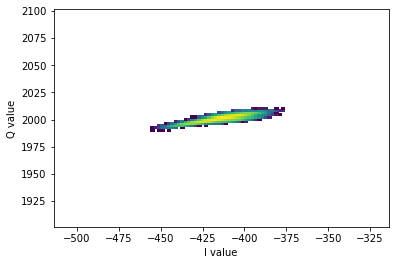

In [13]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 128, # [us]
    'reps': 100000
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs
config['pulse_gain'] = 10000
prog = SingleGenLoopbackProgram(soccfg, config)
# res = prog.acquire(soc, load_pulses=True, progress=False) # warmup
res = prog.acquire(soc, load_pulses=True, progress=True)

d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
# print(d_buf)
plot_accumulated(res, d_buf, prog, config, span=100)

dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=True)

Text(0.5, 1.0, 'phase vs. time')

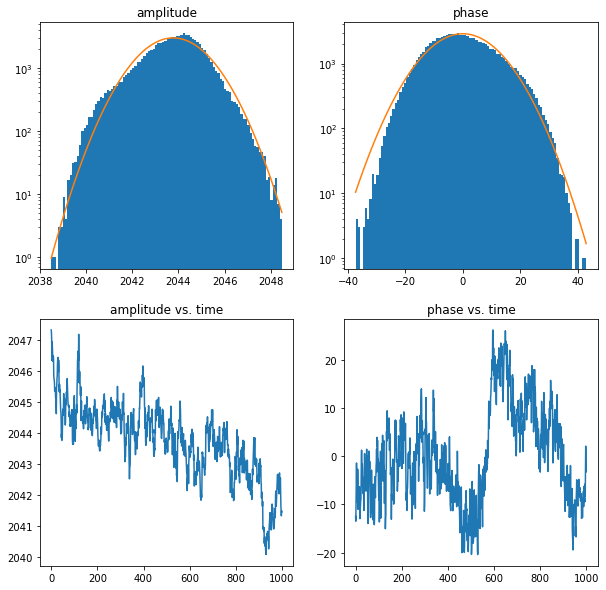

In [14]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
_,bins,_ = axs[0,0].hist(magerr, bins=100, log=True)
params = stats.norm.fit(magerr)
axs[0,0].plot(bins, len(magerr)*(bins[1]-bins[0])*stats.norm.pdf(bins, *params))
axs[0,0].set_title("amplitude")
axs[1,0].plot(magerr.reshape((1000,-1)).mean(axis=1))
axs[1,0].set_title("amplitude vs. time")
_,bins,_ = axs[0,1].hist(phaerr, bins=100, log=True)
params = stats.norm.fit(phaerr)
axs[0,1].plot(bins, len(phaerr)*(bins[1]-bins[0])*stats.norm.pdf(bins, *params))
axs[0,1].set_title("phase")
axs[1,1].plot(phaerr.reshape((1000,-1)).mean(axis=1))
axs[1,1].set_title("phase vs. time")


### IF sweep
Note the 3 dB increase in amplitude noise above ~900 MHz, from (as mentioned earlier) incomplete filtering of the ADC's second Nyquist zone.

  0%|          | 0/59 [00:00<?, ?it/s]

Text(0, 0.5, 'amplitude [ADU]')

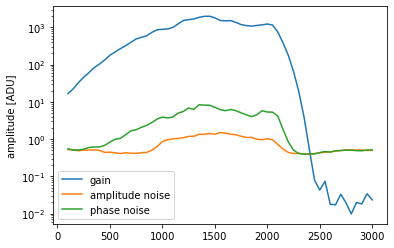

In [15]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 10, # [us]
    'reps': 1000
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs

freqs = np.arange(100, 3001, 50, dtype=float)
mags = np.zeros_like(freqs)
noises = np.zeros_like(freqs)
noise_phase = np.zeros_like(freqs)

for i, f in tqdm(list(enumerate(freqs))):
    config['if_res'] = f
    
    prog = SingleGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    
    d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
    
    dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
    mags[i] = dmag
    noises[i] = rmsmag
    noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags, label='gain')
plt.semilogy(freqs, noises, label='amplitude noise')
plt.semilogy(freqs, noise_phase, label='phase noise')
plt.legend()
plt.ylabel("amplitude [ADU]")


### noise measurements with different powers and attenuations

#### three different ADC attenuations
External attenuation of 40 dB.

By sweeping the integration time (and thus the resolution bandwidth), we can break down the noise components further.
* white noise, which dominates at small integration times - this is broadband and is described by a power density (ADU^2/Hz)
* signal noise, which can be measured at large integration times - this comes from fluctuations in the signal tone and is described by a power (ADU^2)

Note that the signal-to-noise does not depend on the ADC attenuation - look at the gain=100 scan, SNR=1 is always at 3-4 us.
In other words, in our room-temperature setup the noise before the attenuator always dominates (as it should).

The amplitude noise is pretty close to white even for very long integration times. As we already saw above, the phase noise is not white.

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 3.09e+04 ADU^2, noise (mag, pha) (2.75e+02, 2.75e+02) ADU^2, (1.72e-05, 1.72e-05) ADU^2/Hz
  0.125 us: signal 3.08e+04 ADU^2, noise (mag, pha) (1.40e+02, 1.47e+02) ADU^2, (1.75e-05, 1.84e-05) ADU^2/Hz
  0.250 us: signal 3.08e+04 ADU^2, noise (mag, pha) (6.99e+01, 7.15e+01) ADU^2, (1.75e-05, 1.79e-05) ADU^2/Hz
  0.500 us: signal 3.09e+04 ADU^2, noise (mag, pha) (3.57e+01, 3.66e+01) ADU^2, (1.78e-05, 1.83e-05) ADU^2/Hz
  1.000 us: signal 3.09e+04 ADU^2, noise (mag, pha) (1.79e+01, 1.89e+01) ADU^2, (1.79e-05, 1.89e-05) ADU^2/Hz
  2.000 us: signal 3.09e+04 ADU^2, noise (mag, pha) (8.86e+00, 9.74e+00) ADU^2, (1.77e-05, 1.95e-05) ADU^2/Hz
  4.000 us: signal 3.09e+04 ADU^2, noise (mag, pha) (4.45e+00, 5.18e+00) ADU^2, (1.78e-05, 2.07e-05) ADU^2/Hz
  8.000 us: signal 3.09e+04 ADU^2, noise (mag, pha) (2.23e+00, 2.83e+00) ADU^2, (1.79e-05, 2.26e-05) ADU^2/Hz
 16.000 us: signal 3.09e+04 ADU^2, noise (mag, pha) (1.08e+00, 1.68e+00) ADU^2, (1.72e-05, 2.68e-05) ADU^2/Hz
 32.000 us

array([-1.56784703e-03,  1.77405936e-05])

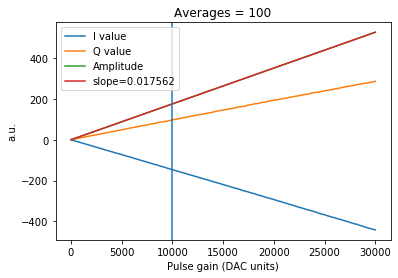

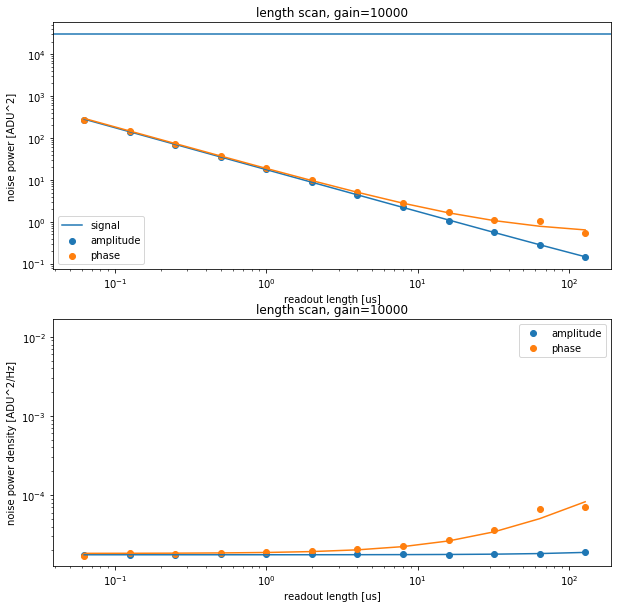

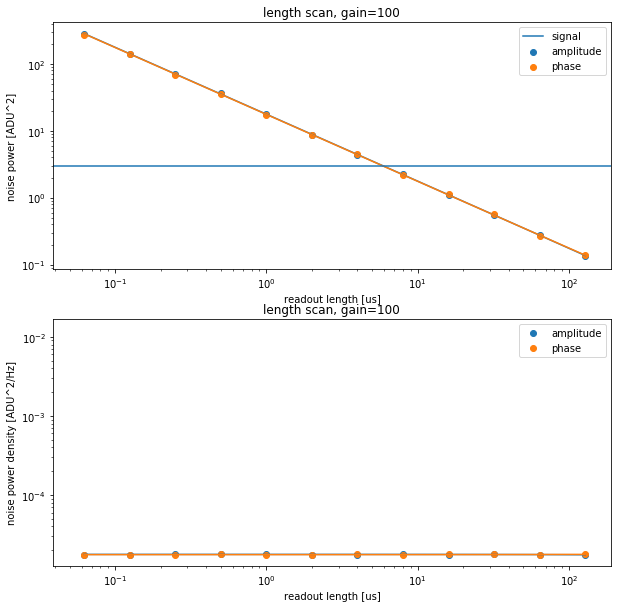

In [16]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=30)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(10000)
length_scan(10000)
length_scan(100)

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 3.52e+05 ADU^2, noise (mag, pha) (2.92e+03, 3.01e+03) ADU^2, (1.83e-04, 1.88e-04) ADU^2/Hz
  0.125 us: signal 3.51e+05 ADU^2, noise (mag, pha) (1.51e+03, 1.55e+03) ADU^2, (1.89e-04, 1.93e-04) ADU^2/Hz
  0.250 us: signal 3.49e+05 ADU^2, noise (mag, pha) (7.49e+02, 7.91e+02) ADU^2, (1.87e-04, 1.98e-04) ADU^2/Hz
  0.500 us: signal 3.51e+05 ADU^2, noise (mag, pha) (3.88e+02, 4.02e+02) ADU^2, (1.94e-04, 2.01e-04) ADU^2/Hz
  1.000 us: signal 3.51e+05 ADU^2, noise (mag, pha) (1.85e+02, 2.09e+02) ADU^2, (1.85e-04, 2.09e-04) ADU^2/Hz
  2.000 us: signal 3.51e+05 ADU^2, noise (mag, pha) (9.64e+01, 1.07e+02) ADU^2, (1.93e-04, 2.13e-04) ADU^2/Hz
  4.000 us: signal 3.50e+05 ADU^2, noise (mag, pha) (4.77e+01, 5.71e+01) ADU^2, (1.91e-04, 2.28e-04) ADU^2/Hz
  8.000 us: signal 3.50e+05 ADU^2, noise (mag, pha) (2.38e+01, 2.94e+01) ADU^2, (1.91e-04, 2.35e-04) ADU^2/Hz
 16.000 us: signal 3.50e+05 ADU^2, noise (mag, pha) (1.19e+01, 1.76e+01) ADU^2, (1.90e-04, 2.82e-04) ADU^2/Hz
 32.000 us

array([-0.03395074,  0.00019187])

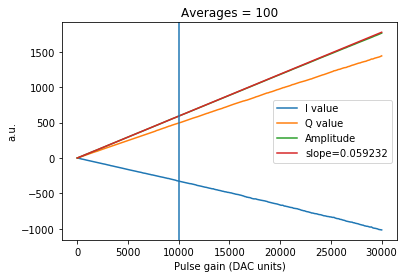

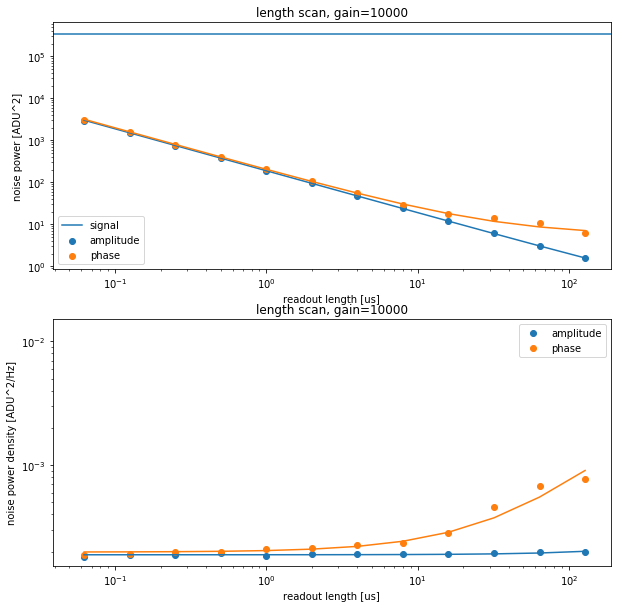

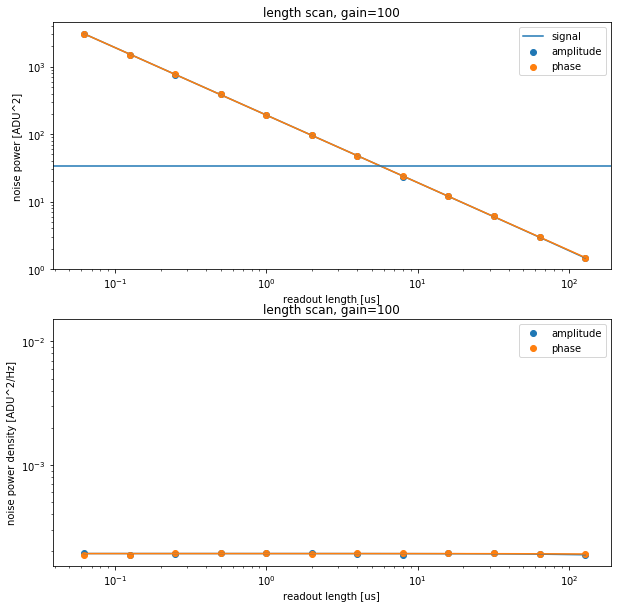

In [17]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=30)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=20)
check_linearity(10000)
length_scan(10000)
length_scan(100)

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 4.40e+06 ADU^2, noise (mag, pha) (3.17e+04, 3.28e+04) ADU^2, (1.98e-03, 2.05e-03) ADU^2/Hz
  0.125 us: signal 4.41e+06 ADU^2, noise (mag, pha) (1.60e+04, 1.69e+04) ADU^2, (2.00e-03, 2.11e-03) ADU^2/Hz
  0.250 us: signal 4.39e+06 ADU^2, noise (mag, pha) (8.10e+03, 8.53e+03) ADU^2, (2.02e-03, 2.13e-03) ADU^2/Hz
  0.500 us: signal 4.39e+06 ADU^2, noise (mag, pha) (4.16e+03, 4.41e+03) ADU^2, (2.08e-03, 2.20e-03) ADU^2/Hz
  1.000 us: signal 4.39e+06 ADU^2, noise (mag, pha) (1.97e+03, 2.30e+03) ADU^2, (1.97e-03, 2.30e-03) ADU^2/Hz
  2.000 us: signal 4.39e+06 ADU^2, noise (mag, pha) (1.02e+03, 1.21e+03) ADU^2, (2.04e-03, 2.41e-03) ADU^2/Hz
  4.000 us: signal 4.39e+06 ADU^2, noise (mag, pha) (5.02e+02, 6.10e+02) ADU^2, (2.01e-03, 2.44e-03) ADU^2/Hz
  8.000 us: signal 4.39e+06 ADU^2, noise (mag, pha) (2.55e+02, 3.45e+02) ADU^2, (2.04e-03, 2.76e-03) ADU^2/Hz
 16.000 us: signal 4.39e+06 ADU^2, noise (mag, pha) (1.33e+02, 2.33e+02) ADU^2, (2.12e-03, 3.72e-03) ADU^2/Hz
 32.000 us

array([0.18870137, 0.00215095])

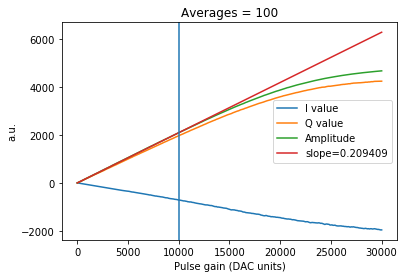

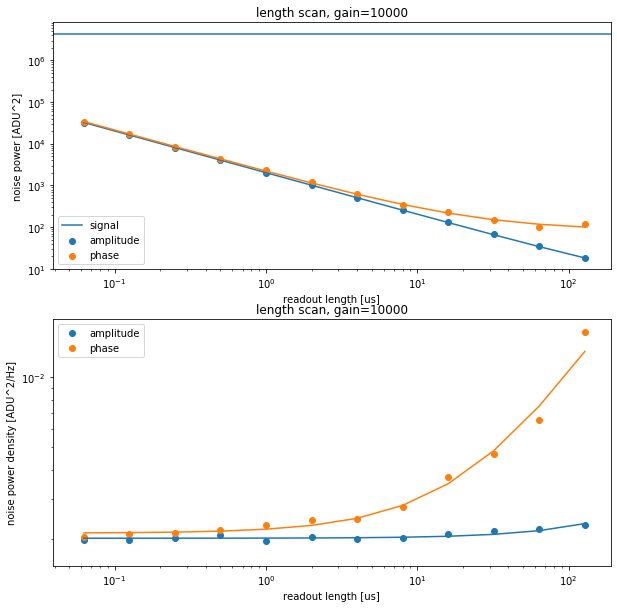

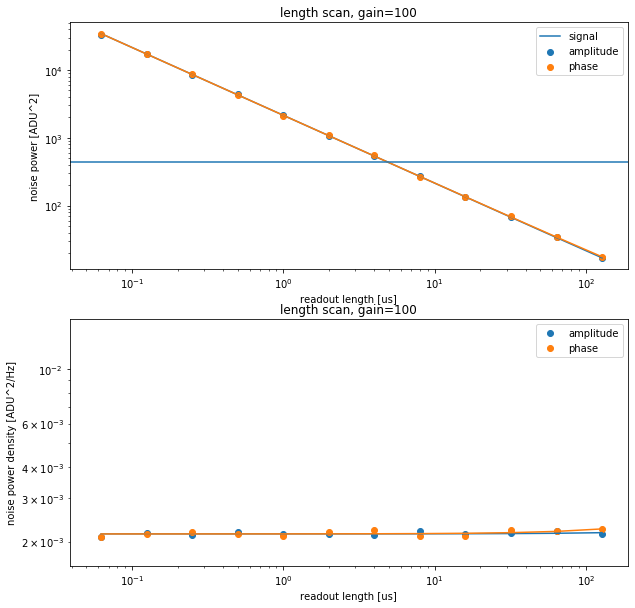

In [18]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=30)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=10)
check_linearity(10000)
length_scan(10000)
length_scan(100)

#### three different DAC attenuations
Again, external attenuation of 40 dB.

Note that the noise power density is consistently ~1.5e-5 ADU^2/Hz.
The 40 dB external attenuator reduces noise from the DAC chain to below the room-temperature background.

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 3.05e+04 ADU^2, noise (mag, pha) (2.74e+02, 2.80e+02) ADU^2, (1.71e-05, 1.75e-05) ADU^2/Hz
  0.125 us: signal 3.06e+04 ADU^2, noise (mag, pha) (1.41e+02, 1.42e+02) ADU^2, (1.76e-05, 1.77e-05) ADU^2/Hz
  0.250 us: signal 3.07e+04 ADU^2, noise (mag, pha) (7.16e+01, 7.19e+01) ADU^2, (1.79e-05, 1.80e-05) ADU^2/Hz
  0.500 us: signal 3.06e+04 ADU^2, noise (mag, pha) (3.44e+01, 3.64e+01) ADU^2, (1.72e-05, 1.82e-05) ADU^2/Hz
  1.000 us: signal 3.06e+04 ADU^2, noise (mag, pha) (1.75e+01, 1.91e+01) ADU^2, (1.75e-05, 1.91e-05) ADU^2/Hz
  2.000 us: signal 3.06e+04 ADU^2, noise (mag, pha) (8.89e+00, 9.70e+00) ADU^2, (1.78e-05, 1.94e-05) ADU^2/Hz
  4.000 us: signal 3.06e+04 ADU^2, noise (mag, pha) (4.45e+00, 5.10e+00) ADU^2, (1.78e-05, 2.04e-05) ADU^2/Hz
  8.000 us: signal 3.06e+04 ADU^2, noise (mag, pha) (2.26e+00, 2.83e+00) ADU^2, (1.81e-05, 2.26e-05) ADU^2/Hz
 16.000 us: signal 3.06e+04 ADU^2, noise (mag, pha) (1.09e+00, 1.61e+00) ADU^2, (1.74e-05, 2.58e-05) ADU^2/Hz
 32.000 us

array([4.74112075e-04, 1.75825246e-05])

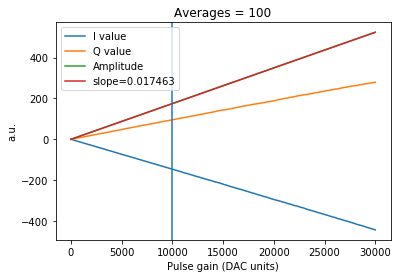

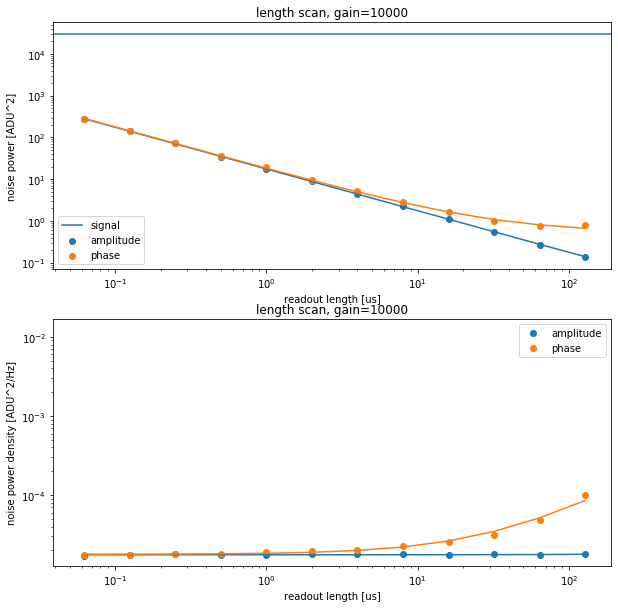

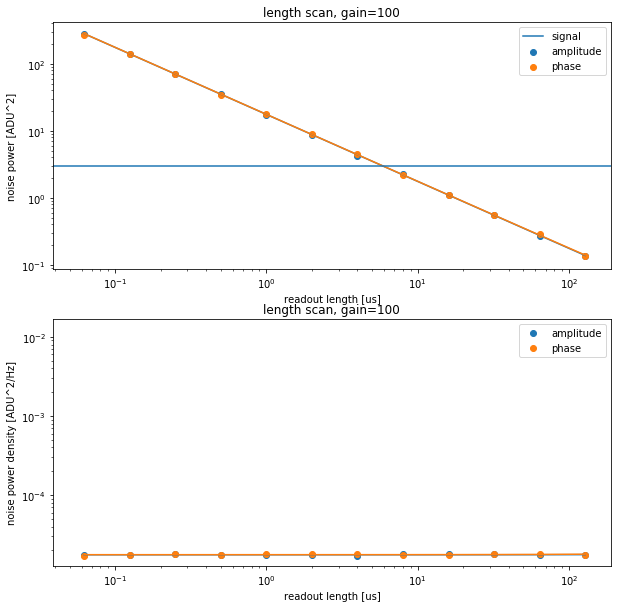

In [19]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=30)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(10000)
length_scan(10000)
length_scan(100)

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 3.41e+05 ADU^2, noise (mag, pha) (2.83e+02, 2.91e+02) ADU^2, (1.77e-05, 1.82e-05) ADU^2/Hz
  0.125 us: signal 3.41e+05 ADU^2, noise (mag, pha) (1.37e+02, 1.55e+02) ADU^2, (1.71e-05, 1.94e-05) ADU^2/Hz
  0.250 us: signal 3.41e+05 ADU^2, noise (mag, pha) (7.18e+01, 8.23e+01) ADU^2, (1.80e-05, 2.06e-05) ADU^2/Hz
  0.500 us: signal 3.41e+05 ADU^2, noise (mag, pha) (3.45e+01, 4.79e+01) ADU^2, (1.73e-05, 2.39e-05) ADU^2/Hz
  1.000 us: signal 3.40e+05 ADU^2, noise (mag, pha) (1.74e+01, 2.91e+01) ADU^2, (1.74e-05, 2.91e-05) ADU^2/Hz
  2.000 us: signal 3.41e+05 ADU^2, noise (mag, pha) (8.64e+00, 1.84e+01) ADU^2, (1.73e-05, 3.68e-05) ADU^2/Hz
  4.000 us: signal 3.40e+05 ADU^2, noise (mag, pha) (4.45e+00, 1.16e+01) ADU^2, (1.78e-05, 4.63e-05) ADU^2/Hz
  8.000 us: signal 3.41e+05 ADU^2, noise (mag, pha) (2.23e+00, 9.16e+00) ADU^2, (1.78e-05, 7.33e-05) ADU^2/Hz
 16.000 us: signal 3.41e+05 ADU^2, noise (mag, pha) (1.12e+00, 8.36e+00) ADU^2, (1.79e-05, 1.34e-04) ADU^2/Hz
 32.000 us

array([-6.23378906e-04,  1.75966514e-05])

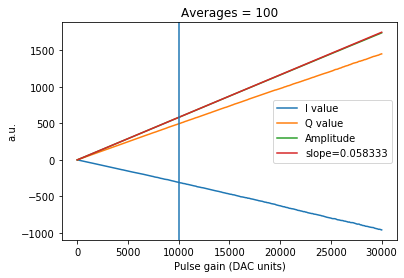

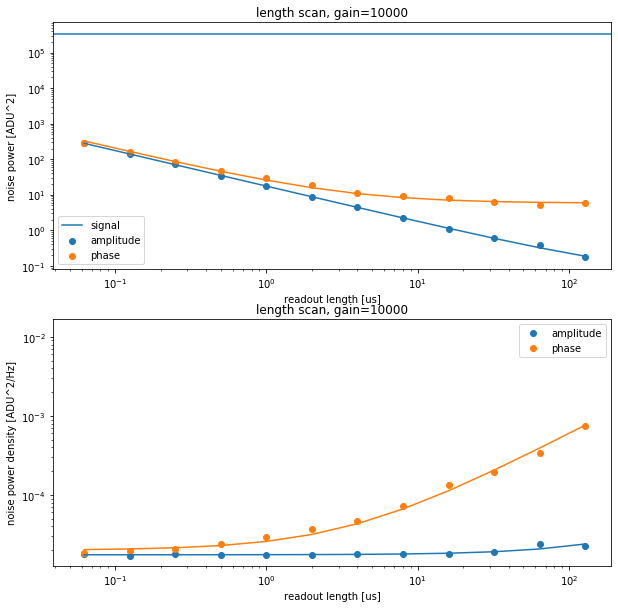

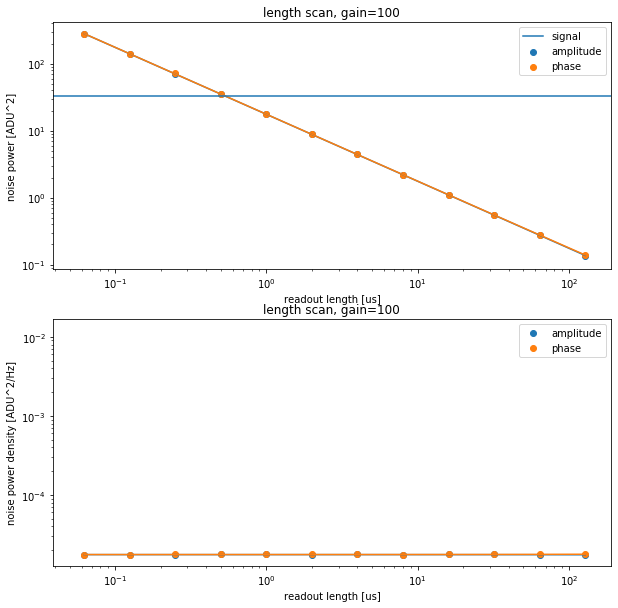

In [20]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=20)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(10000)
length_scan(10000)
length_scan(100)

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 4.05e+06 ADU^2, noise (mag, pha) (2.70e+02, 4.33e+02) ADU^2, (1.69e-05, 2.71e-05) ADU^2/Hz
  0.125 us: signal 4.05e+06 ADU^2, noise (mag, pha) (1.35e+02, 2.93e+02) ADU^2, (1.68e-05, 3.66e-05) ADU^2/Hz
  0.250 us: signal 4.05e+06 ADU^2, noise (mag, pha) (6.89e+01, 2.24e+02) ADU^2, (1.72e-05, 5.60e-05) ADU^2/Hz
  0.500 us: signal 4.05e+06 ADU^2, noise (mag, pha) (3.33e+01, 1.78e+02) ADU^2, (1.67e-05, 8.90e-05) ADU^2/Hz
  1.000 us: signal 4.05e+06 ADU^2, noise (mag, pha) (1.74e+01, 1.37e+02) ADU^2, (1.74e-05, 1.37e-04) ADU^2/Hz
  2.000 us: signal 4.05e+06 ADU^2, noise (mag, pha) (8.79e+00, 1.19e+02) ADU^2, (1.76e-05, 2.38e-04) ADU^2/Hz
  4.000 us: signal 4.05e+06 ADU^2, noise (mag, pha) (4.63e+00, 8.34e+01) ADU^2, (1.85e-05, 3.34e-04) ADU^2/Hz
  8.000 us: signal 4.05e+06 ADU^2, noise (mag, pha) (2.45e+00, 7.62e+01) ADU^2, (1.96e-05, 6.09e-04) ADU^2/Hz
 16.000 us: signal 4.05e+06 ADU^2, noise (mag, pha) (1.40e+00, 7.16e+01) ADU^2, (2.23e-05, 1.15e-03) ADU^2/Hz
 32.000 us

array([9.08496668e-04, 1.76045526e-05])

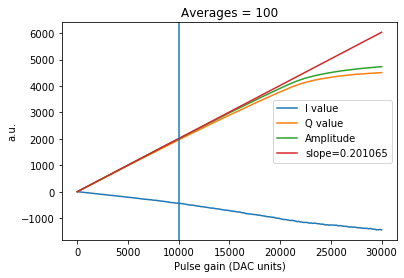

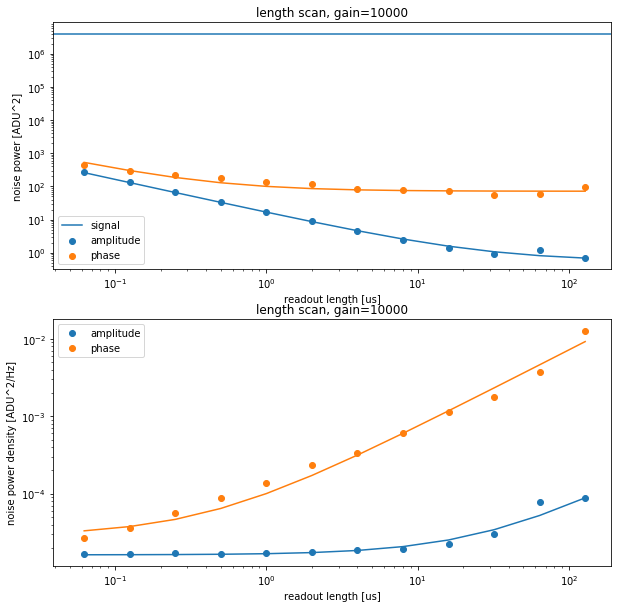

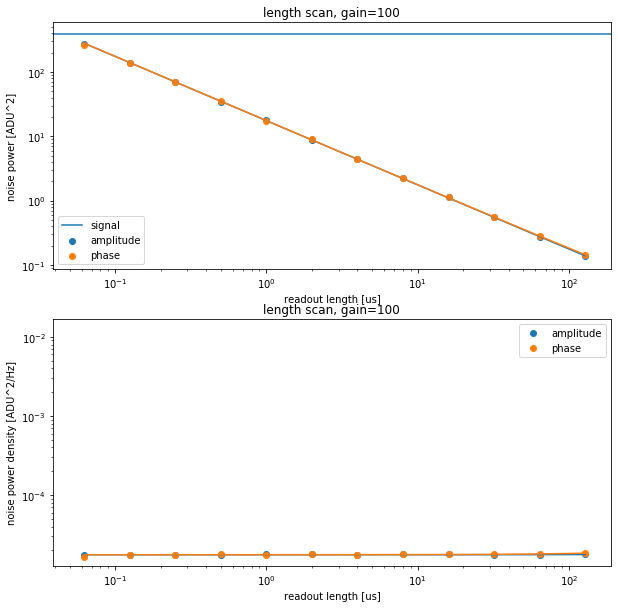

In [21]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=10)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(10000)
length_scan(10000)
length_scan(100)

### Noise-only measurement
I put a terminator on the ADC port. Noise is close to what was measured above for the same ADC attenuations.

  0.062 us: signal 1.35e-02 ADU^2, noise (mag, pha) (2.69e+02, 2.58e+02) ADU^2, (1.68e-05, 1.61e-05) ADU^2/Hz
  0.125 us: signal 1.11e-02 ADU^2, noise (mag, pha) (1.33e+02, 1.34e+02) ADU^2, (1.67e-05, 1.67e-05) ADU^2/Hz
  0.250 us: signal 9.76e-03 ADU^2, noise (mag, pha) (6.81e+01, 7.01e+01) ADU^2, (1.70e-05, 1.75e-05) ADU^2/Hz
  0.500 us: signal 2.07e-02 ADU^2, noise (mag, pha) (3.29e+01, 3.39e+01) ADU^2, (1.64e-05, 1.70e-05) ADU^2/Hz
  1.000 us: signal 9.64e-04 ADU^2, noise (mag, pha) (1.68e+01, 1.74e+01) ADU^2, (1.68e-05, 1.74e-05) ADU^2/Hz
  2.000 us: signal 7.18e-05 ADU^2, noise (mag, pha) (8.40e+00, 8.76e+00) ADU^2, (1.68e-05, 1.75e-05) ADU^2/Hz
  4.000 us: signal 3.60e-04 ADU^2, noise (mag, pha) (4.18e+00, 4.24e+00) ADU^2, (1.67e-05, 1.70e-05) ADU^2/Hz
  8.000 us: signal 5.99e-04 ADU^2, noise (mag, pha) (2.12e+00, 2.10e+00) ADU^2, (1.70e-05, 1.68e-05) ADU^2/Hz
 16.000 us: signal 7.31e-04 ADU^2, noise (mag, pha) (1.05e+00, 1.04e+00) ADU^2, (1.67e-05, 1.66e-05) ADU^2/Hz
 32.000 us

array([1.02169707e-04, 1.68237774e-05])

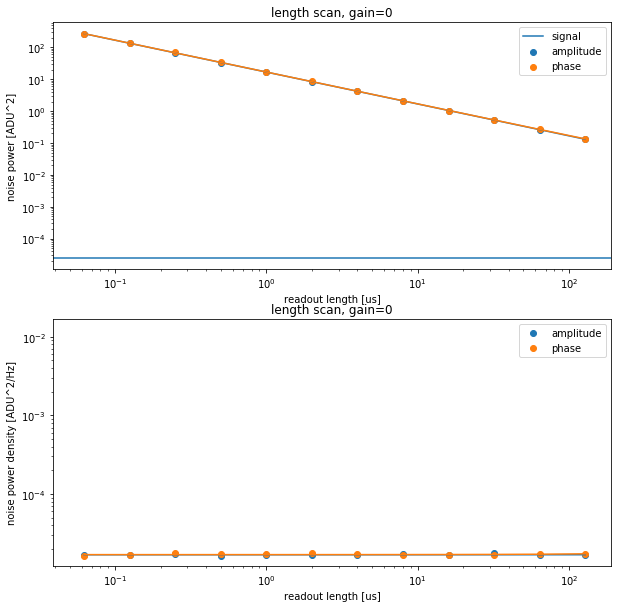

In [22]:
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
length_scan(0)

  0.062 us: signal 9.75e+00 ADU^2, noise (mag, pha) (3.17e+04, 3.15e+04) ADU^2, (1.98e-03, 1.97e-03) ADU^2/Hz
  0.125 us: signal 4.19e+00 ADU^2, noise (mag, pha) (1.62e+04, 1.62e+04) ADU^2, (2.02e-03, 2.03e-03) ADU^2/Hz
  0.250 us: signal 4.51e-01 ADU^2, noise (mag, pha) (8.05e+03, 8.06e+03) ADU^2, (2.01e-03, 2.02e-03) ADU^2/Hz
  0.500 us: signal 7.90e-02 ADU^2, noise (mag, pha) (4.03e+03, 3.93e+03) ADU^2, (2.02e-03, 1.96e-03) ADU^2/Hz
  1.000 us: signal 2.98e-01 ADU^2, noise (mag, pha) (1.99e+03, 2.00e+03) ADU^2, (1.99e-03, 2.00e-03) ADU^2/Hz
  2.000 us: signal 1.60e-01 ADU^2, noise (mag, pha) (1.02e+03, 1.02e+03) ADU^2, (2.04e-03, 2.03e-03) ADU^2/Hz
  4.000 us: signal 5.42e-02 ADU^2, noise (mag, pha) (5.06e+02, 4.99e+02) ADU^2, (2.03e-03, 2.00e-03) ADU^2/Hz
  8.000 us: signal 2.62e-01 ADU^2, noise (mag, pha) (2.55e+02, 2.66e+02) ADU^2, (2.04e-03, 2.13e-03) ADU^2/Hz
 16.000 us: signal 1.14e-02 ADU^2, noise (mag, pha) (1.28e+02, 1.29e+02) ADU^2, (2.04e-03, 2.07e-03) ADU^2/Hz
 32.000 us

array([0.1336102, 0.0020191])

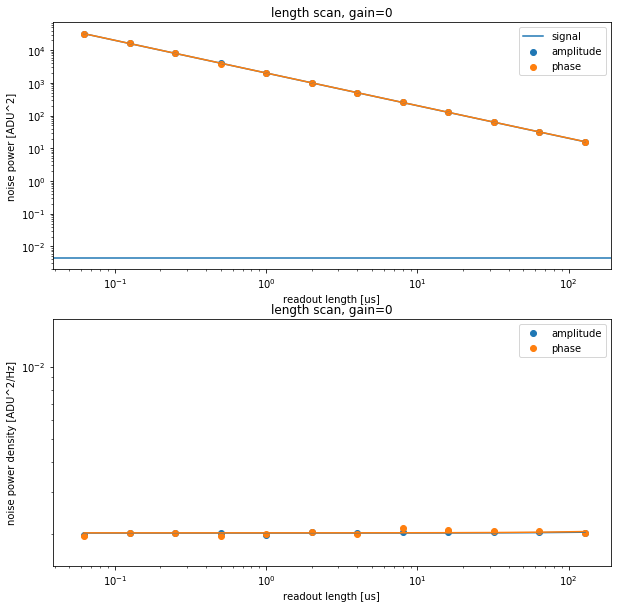

In [23]:
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=10)
length_scan(0)

#### No external attenuation
Without external attenuation, we see more white noise, and it changes when we change the DAC attenuation. So we are seeing the noise of the DAC chain.

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 4.63e+04 ADU^2, noise (mag, pha) (5.41e+03, 5.38e+03) ADU^2, (3.38e-04, 3.36e-04) ADU^2/Hz
  0.125 us: signal 4.61e+04 ADU^2, noise (mag, pha) (2.86e+03, 2.78e+03) ADU^2, (3.58e-04, 3.47e-04) ADU^2/Hz
  0.250 us: signal 4.60e+04 ADU^2, noise (mag, pha) (1.42e+03, 1.43e+03) ADU^2, (3.54e-04, 3.58e-04) ADU^2/Hz
  0.500 us: signal 4.61e+04 ADU^2, noise (mag, pha) (6.96e+02, 7.09e+02) ADU^2, (3.48e-04, 3.55e-04) ADU^2/Hz
  1.000 us: signal 4.60e+04 ADU^2, noise (mag, pha) (3.56e+02, 3.60e+02) ADU^2, (3.56e-04, 3.60e-04) ADU^2/Hz
  2.000 us: signal 4.60e+04 ADU^2, noise (mag, pha) (1.72e+02, 1.79e+02) ADU^2, (3.44e-04, 3.57e-04) ADU^2/Hz
  4.000 us: signal 4.61e+04 ADU^2, noise (mag, pha) (8.91e+01, 8.97e+01) ADU^2, (3.56e-04, 3.59e-04) ADU^2/Hz
  8.000 us: signal 4.59e+04 ADU^2, noise (mag, pha) (4.46e+01, 4.65e+01) ADU^2, (3.57e-04, 3.72e-04) ADU^2/Hz
 16.000 us: signal 4.59e+04 ADU^2, noise (mag, pha) (2.22e+01, 2.27e+01) ADU^2, (3.55e-04, 3.64e-04) ADU^2/Hz
 32.000 us

array([0.13935867, 0.00035123])

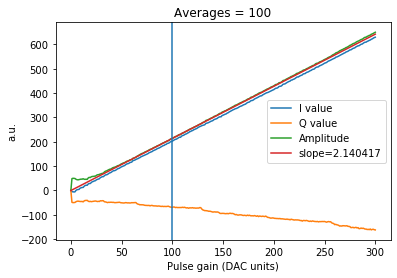

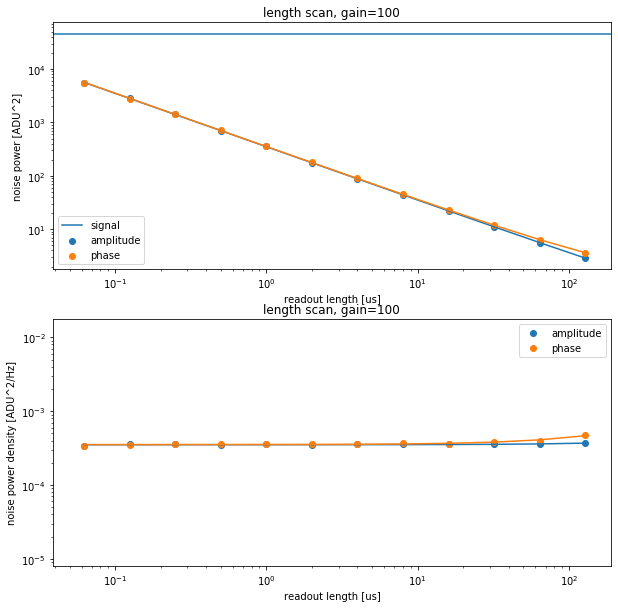

In [24]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=30)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(100)
length_scan(100)

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 5.28e+05 ADU^2, noise (mag, pha) (7.29e+03, 7.28e+03) ADU^2, (4.56e-04, 4.55e-04) ADU^2/Hz
  0.125 us: signal 5.27e+05 ADU^2, noise (mag, pha) (3.70e+03, 3.83e+03) ADU^2, (4.62e-04, 4.79e-04) ADU^2/Hz
  0.250 us: signal 5.26e+05 ADU^2, noise (mag, pha) (1.88e+03, 1.88e+03) ADU^2, (4.71e-04, 4.70e-04) ADU^2/Hz
  0.500 us: signal 5.25e+05 ADU^2, noise (mag, pha) (9.51e+02, 9.38e+02) ADU^2, (4.76e-04, 4.69e-04) ADU^2/Hz
  1.000 us: signal 5.26e+05 ADU^2, noise (mag, pha) (4.82e+02, 4.74e+02) ADU^2, (4.82e-04, 4.74e-04) ADU^2/Hz
  2.000 us: signal 5.26e+05 ADU^2, noise (mag, pha) (2.33e+02, 2.51e+02) ADU^2, (4.65e-04, 5.02e-04) ADU^2/Hz
  4.000 us: signal 5.26e+05 ADU^2, noise (mag, pha) (1.24e+02, 1.30e+02) ADU^2, (4.95e-04, 5.22e-04) ADU^2/Hz
  8.000 us: signal 5.26e+05 ADU^2, noise (mag, pha) (6.04e+01, 6.91e+01) ADU^2, (4.83e-04, 5.53e-04) ADU^2/Hz
 16.000 us: signal 5.26e+05 ADU^2, noise (mag, pha) (2.99e+01, 3.95e+01) ADU^2, (4.78e-04, 6.32e-04) ADU^2/Hz
 32.000 us

array([0.19038634, 0.00047353])

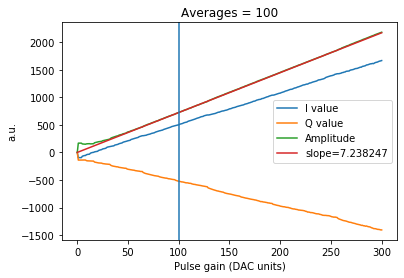

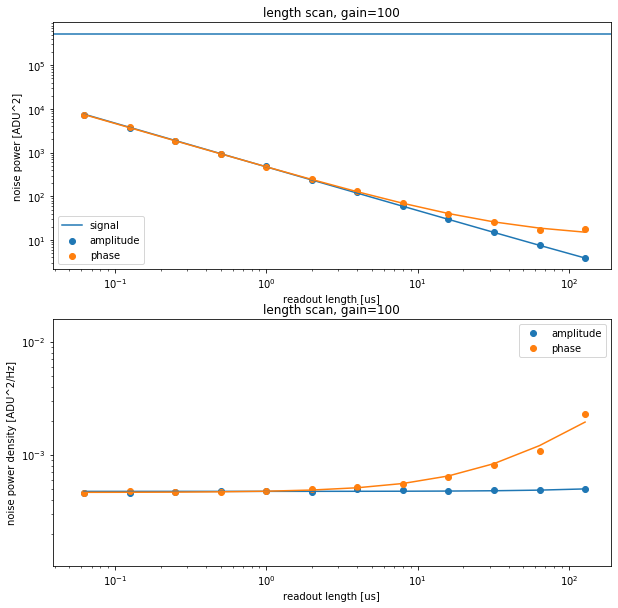

In [25]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=20)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(100)
length_scan(100)

  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 5.64e+06 ADU^2, noise (mag, pha) (2.64e+04, 2.72e+04) ADU^2, (1.65e-03, 1.70e-03) ADU^2/Hz
  0.125 us: signal 5.66e+06 ADU^2, noise (mag, pha) (1.36e+04, 1.44e+04) ADU^2, (1.70e-03, 1.81e-03) ADU^2/Hz
  0.250 us: signal 5.67e+06 ADU^2, noise (mag, pha) (6.78e+03, 7.19e+03) ADU^2, (1.70e-03, 1.80e-03) ADU^2/Hz
  0.500 us: signal 5.67e+06 ADU^2, noise (mag, pha) (3.41e+03, 3.70e+03) ADU^2, (1.70e-03, 1.85e-03) ADU^2/Hz
  1.000 us: signal 5.68e+06 ADU^2, noise (mag, pha) (1.66e+03, 1.97e+03) ADU^2, (1.66e-03, 1.97e-03) ADU^2/Hz
  2.000 us: signal 5.67e+06 ADU^2, noise (mag, pha) (8.54e+02, 1.05e+03) ADU^2, (1.71e-03, 2.09e-03) ADU^2/Hz
  4.000 us: signal 5.67e+06 ADU^2, noise (mag, pha) (4.24e+02, 5.80e+02) ADU^2, (1.70e-03, 2.32e-03) ADU^2/Hz
  8.000 us: signal 5.67e+06 ADU^2, noise (mag, pha) (2.20e+02, 3.33e+02) ADU^2, (1.76e-03, 2.66e-03) ADU^2/Hz
 16.000 us: signal 5.67e+06 ADU^2, noise (mag, pha) (1.12e+02, 2.31e+02) ADU^2, (1.80e-03, 3.70e-03) ADU^2/Hz
 32.000 us

array([5.75587843e+00, 1.67818965e-03])

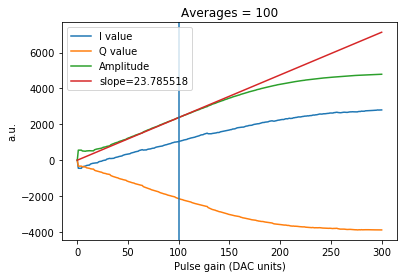

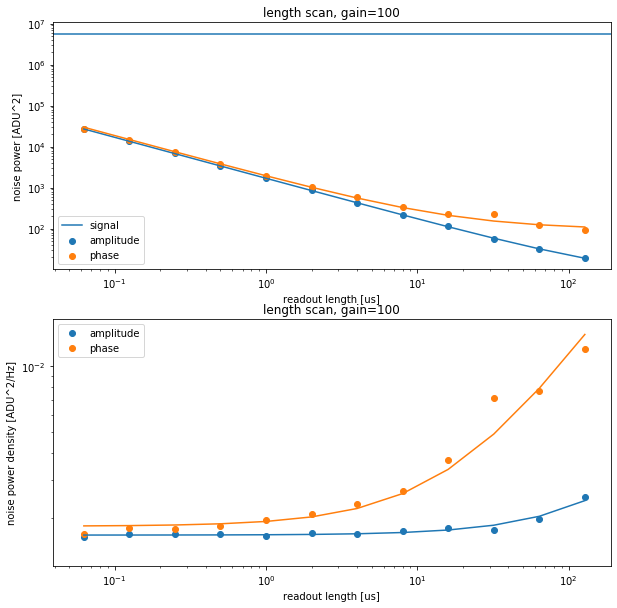

In [26]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=10)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(100)
length_scan(100)

### Power measurement

Measure the real power (with default settings - 0+10 dB DAC attenuation), so we can normalize powers from ADU^2 to real units.

**All measurements (QICK and spectrum analyzer) are made with the same longish cable, which has ~3 dB loss at this frequency.**

without attenuator

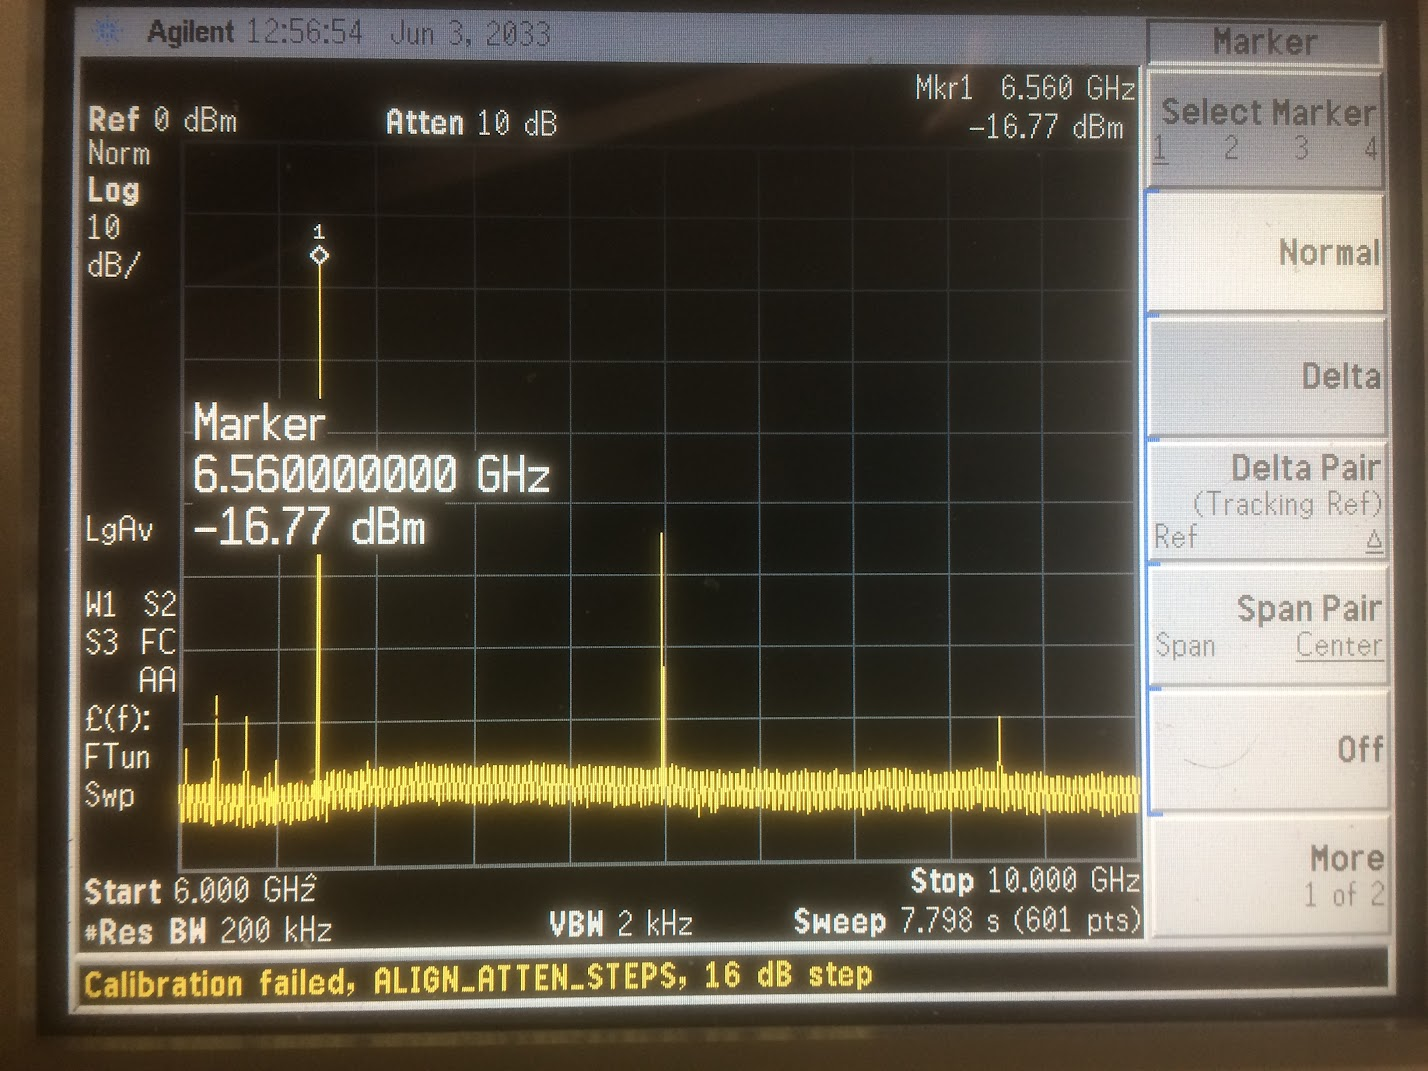

with 40 dB attenuator

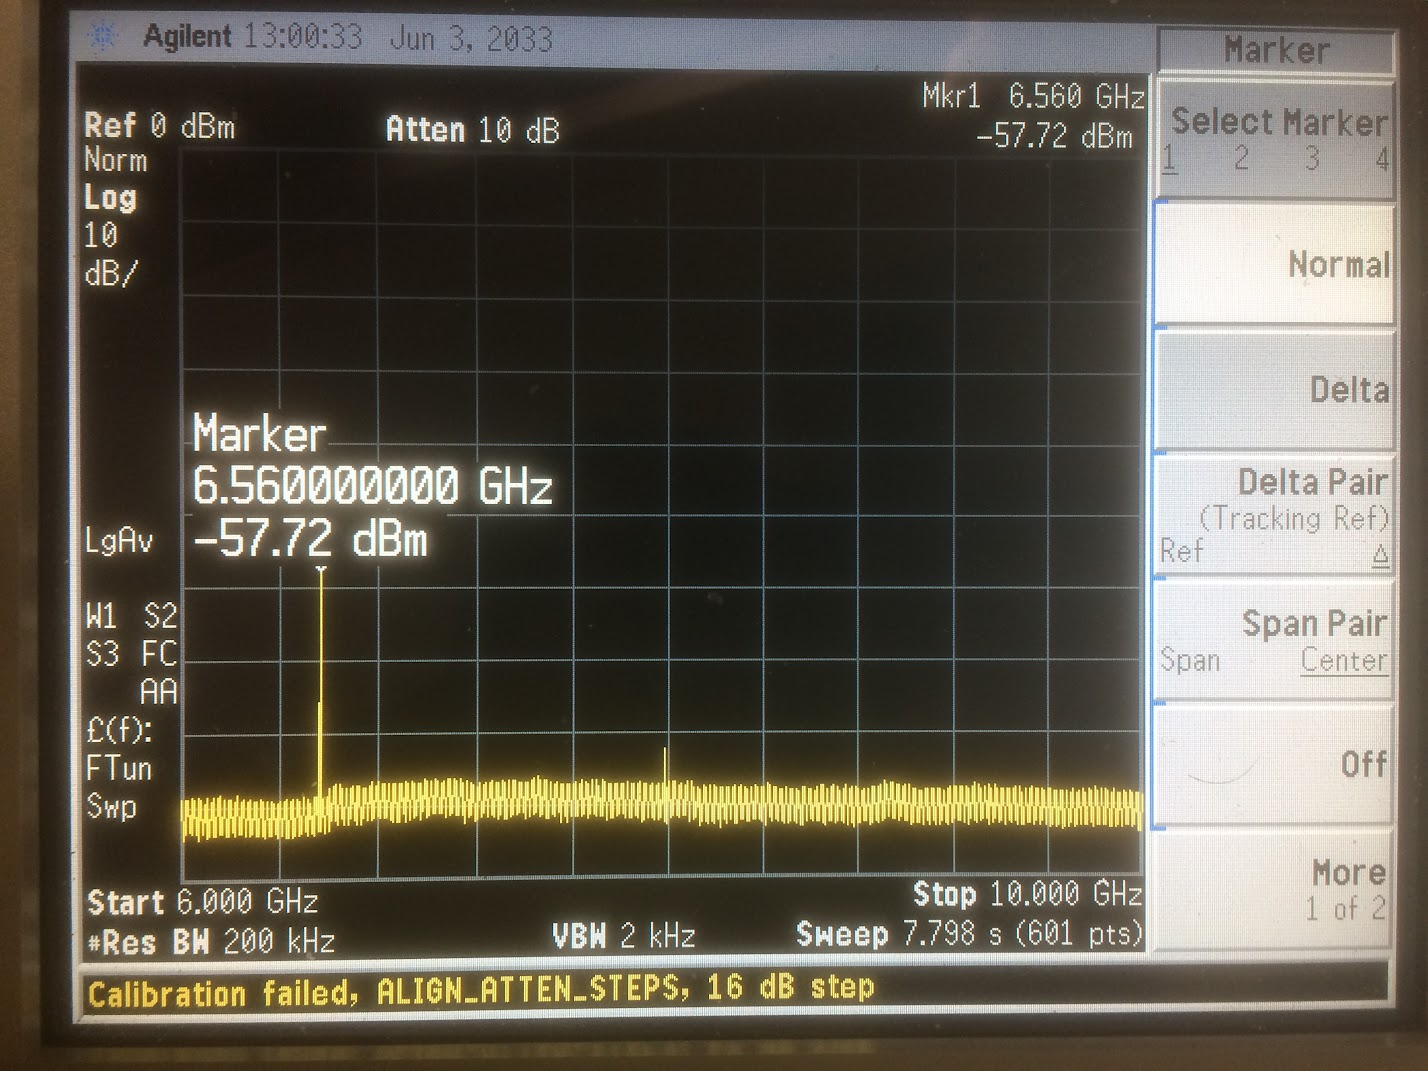

So we see -54.57 dBm at 40 dB.

This corresponds to the following gain=10000 data (attenuations 0+10 DAC, 40 dB external, 30 ADC):
```
128.000 us: signal 6.05e+06 ADU^2
```

and the following terminator-only data with 30 dB ADC attenuation:
```
amplitude noise -2.76e-04 ADU^2 + 1.55e-05 ADU^2/Hz
phase noise 4.71e-04 ADU^2 + 1.54e-05 ADU^2/Hz
```

Knowing that 6.05e+06 ADU^2 is -57.72 dBm, we can find the conversion factor from ADU^2 to real units.
```
1e-3*10^(-54.57/10) = 3.49e-9 W
3.49e-9/6.05e+06 = 5.77e-16 W/ADU^2
```

Now we can take the white noise we see at the RF board input, and convert it to a noise temperature.

```
so 1.55e-05 ADU^2/Hz * 2.79e-16 W/ADU^2 = 8.94e-21 W/Hz

k_B = 1.38e-23 joules/Kelvin
so (8.94e-21 W/Hz)/k_B = 648 K noise temperature
```

conservatively assuming the actual noise temperature going into the RF board is room temperature (293 K), that means
* the ADC chain is adding ~355 K
* the noise figure is `10*log(648/293)` = 3.45 dB, which is much worse than spec (MAAL-011130 typ. spec is 1.2 dB at 6 GHz, 1.4 dB at 10 GHz)

However - remember that we are getting that doubled noise from putting our IF above 800 MHz. If you account for this, we should be comparing our measured noise against 2x room temperature . . . and we are therefore doing quite well.

<!-- I would not be so sure about the 20 K or 0.29 dB numbers, which seem too good to be true and are pretty sensitive to small errors in measurement, since we are taking a small difference between two numbers.

However I think it is fair to conclude that the ADC chain is not raising the noise temperature significantly over room temperature. -->

In [56]:
dbm_40db = -57.72 # from spectrum analyzer, pulse_gain 10000, attenuations 0+10 dB DAC + 40 dB external
adu2_40db = 4.05e+06 # from QICK, pulse_gain 10000, attenuations 0+10 dB DAC + 40 dB external + 30 dB ADC
adu2_per_hz = 1.68e-05 # from zero-power measurement, attenuations 30 dB ADC

w_per_adu2 = 1e-3*10**(dbm_40db/10)/adu2_40db
print("conversion factor (W per ADU^2): ", w_per_adu2)
k_B = 1.380649e-23
noiseT_total = adu2_per_hz*w_per_adu2/k_B
refT = 293
noiseT_added = noiseT_total - refT
noise_figure = 10*np.log10(noiseT_total/refT)
print("total noise temp %.2f K: %.2f K above 293 K reference level, noise figure %.2f dB"%
      (noiseT_total, noiseT_added, noise_figure))

conversion factor (W per ADU^2):  4.173928226279662e-16
total noise temp 507.89 K: 214.89 K above 293 K reference level, noise figure 2.39 dB


In [30]:
class PeriodicProgram(AveragerProgram):
    def initialize(self):
        cfg = self.cfg
        style = cfg['style']
        
        for iCh, ch in enumerate([cfg["res_ch"]]):  # configure the readout lengths and downconversion frequencies
            length_gen = self.us2cycles(cfg['length'], gen_ch=ch)
            self.declare_gen(ch=ch, nqz=1, ro_ch=cfg["ro_ch"])
            self.default_pulse_registers(ch=ch, 
                         freq=self.freq2reg(cfg["if_res"],gen_ch=ch,ro_ch=cfg["ro_ch"]),
                         gain=cfg['pulse_gain'],
                         phase=0)
            if style == "const":
                self.set_pulse_registers(ch=ch, style=style, length=length_gen, mode='periodic')
                
        length_ro = soccfg.us2cycles(cfg['length']+cfg['readout_padding'], ro_ch=cfg['ro_ch'])
        self.declare_readout(ch=cfg['ro_ch'], freq=cfg["if_res"],
             length=length_ro,
             gen_ch=cfg["res_ch"])

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        self.pulse(ch=self.cfg["res_ch"])

progconfig={
    'style': 'const',
    'length': 0.5,
    'reps': 1,
    'soft_avgs': 1
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs
prog = PeriodicProgram(soccfg, config)
# print(prog)
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

iq_list = prog.acquire_decimated(soc, progress=True)


  0%|          | 0/1 [00:00<?, ?it/s]

In [59]:
# turn off periodic outputs
soc.reset_gens()

## final measurements
* Use short cable (~0.7 dB loss) to reduce error due to shifts in cable attenuation.
* Test three LO frequencies: a high-side value not far above the RF frequency, to keep the IF below 800 MHz, a high-side value far above the RF frequency, to improve filtering of LO leakage, and a low-side value similar to what was used at AQT (5400 MHz)


### low high-side LO

In [107]:
rfb_cfg={
        "f_lo_ro":122.88*59, # 7249.92 - better SNR
#         "f_lo_ro":122.88*65, # 7987.20 - less LO leakage
#          "f_lo_qubit":122.88*28,
        "att_res":(0,15),
#         "att_qubit":(0,16),
         "att_ro":30
       }
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0, verbose=True) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
# soc.rfb_set_gen_rf(gen_ch=hw_cfg['qubit_ch'], att1=rfb_cfg['att_qubit'][0], att2=rfb_cfg['att_qubit'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

meas_cfg={"pulse_gain":10000,
    "if_res": abs(soc.rfb_get_lo(gen_ch=hw_cfg['res_ch']) - hw_cfg['f_res']), # MHz, start value
#     "if_ge": abs(soc.rfb_get_lo(gen_ch=hw_cfg['qubit_ch']) - hw_cfg['f_ge']), # MHz, start value
    "nqz":1,
    'adc_trig_offset': 0.42,
    'length': 10,
    'readout_padding': -0.1,
    'relax_delay': 1
       }

# print("qubit IF=%f, readout IF=%f"%(meas_cfg['if_ge'], meas_cfg['if_res']))
print("readout IF=%f"%(meas_cfg['if_res']))

  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 14499.84 |   2 |       2 |  118 |  False |    1 |    1 |     1 |  122.88 |  7249.92 |    0.00 | 2.3600e+02

Choosing solution 0 with minimal metric 236.
LO locked on attempt 1 after 0.00 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 14499.84 |   2 |       2 |  118 |  False |    1 |    1 |     1 |  122.88 |  7249.92 |    0.00 | 2.3600e+02

Choosing solution 0 with minimal metric 236.
LO locked on attempt 1 after 0.00 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|----

In [108]:
progconfig={
    'style': 'const',
    'length': 0.5,
    'reps': 1,
    'soft_avgs': 1
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs
prog = PeriodicProgram(soccfg, config)
# print(prog)
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

iq_list = prog.acquire_decimated(soc, progress=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Text(0, 0.5, 'amplitude [ADU]')

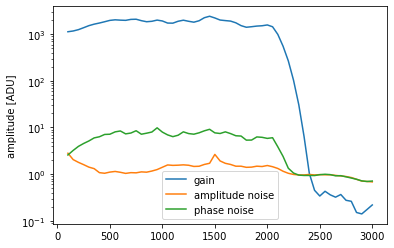

In [71]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 10, # [us]
    'reps': 1000
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs

freqs = np.arange(100, 3001, 50, dtype=float)
mags = np.zeros_like(freqs)
noises = np.zeros_like(freqs)
noise_phase = np.zeros_like(freqs)

for i, f in tqdm(list(enumerate(freqs))):
    config['if_res'] = f
    
    prog = SingleGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    
    d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
    
    dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
    mags[i] = dmag
    noises[i] = rmsmag
    noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags, label='gain')
plt.semilogy(freqs, noises, label='amplitude noise')
plt.semilogy(freqs, noise_phase, label='phase noise')
plt.legend()
plt.ylabel("amplitude [ADU]")


  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 4.25e+06 ADU^2, noise (mag, pha) (1.39e+02, 3.91e+02) ADU^2, (8.71e-06, 2.44e-05) ADU^2/Hz
  0.125 us: signal 4.25e+06 ADU^2, noise (mag, pha) (7.12e+01, 3.08e+02) ADU^2, (8.89e-06, 3.84e-05) ADU^2/Hz
  0.250 us: signal 4.26e+06 ADU^2, noise (mag, pha) (3.47e+01, 2.71e+02) ADU^2, (8.68e-06, 6.78e-05) ADU^2/Hz
  0.500 us: signal 4.26e+06 ADU^2, noise (mag, pha) (1.85e+01, 2.32e+02) ADU^2, (9.25e-06, 1.16e-04) ADU^2/Hz
  1.000 us: signal 4.26e+06 ADU^2, noise (mag, pha) (9.21e+00, 1.87e+02) ADU^2, (9.21e-06, 1.87e-04) ADU^2/Hz
  2.000 us: signal 4.26e+06 ADU^2, noise (mag, pha) (4.74e+00, 1.31e+02) ADU^2, (9.48e-06, 2.63e-04) ADU^2/Hz
  4.000 us: signal 4.26e+06 ADU^2, noise (mag, pha) (2.50e+00, 8.56e+01) ADU^2, (9.98e-06, 3.42e-04) ADU^2/Hz
  8.000 us: signal 4.26e+06 ADU^2, noise (mag, pha) (1.44e+00, 6.80e+01) ADU^2, (1.15e-05, 5.44e-04) ADU^2/Hz
 16.000 us: signal 4.26e+06 ADU^2, noise (mag, pha) (9.33e-01, 6.19e+01) ADU^2, (1.49e-05, 9.90e-04) ADU^2/Hz
 32.000 us

array([3.34434289e-04, 9.00594208e-06])

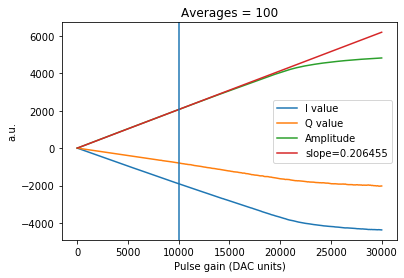

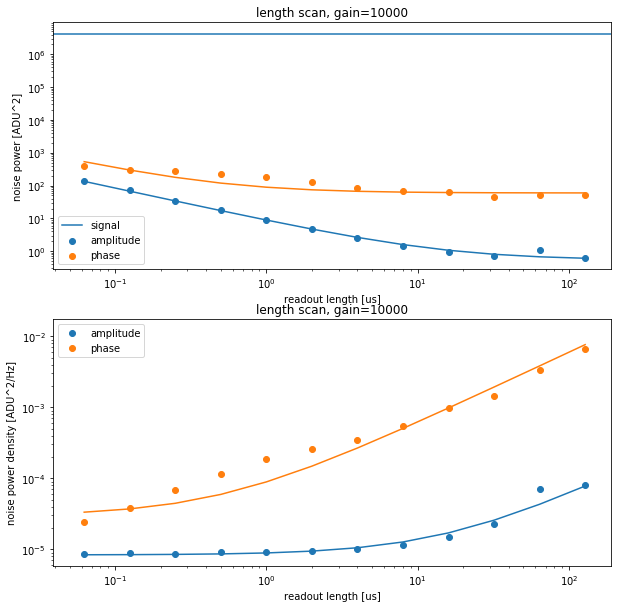

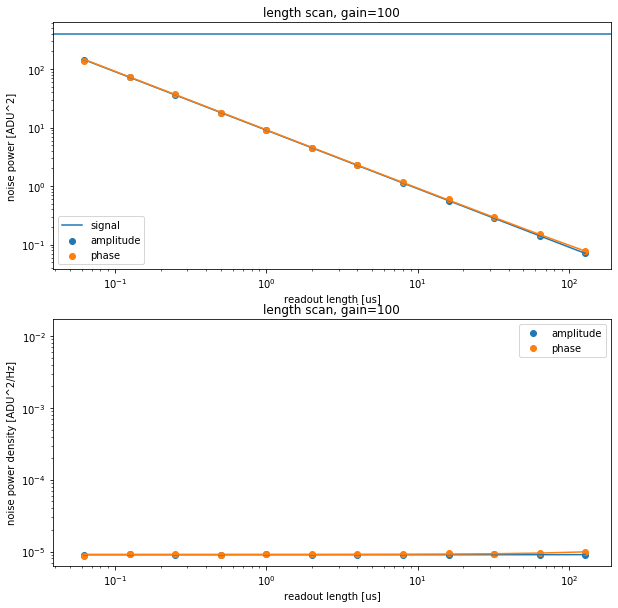

In [74]:
# loopback with 40 dB
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])
check_linearity(10000)
length_scan(10000)
length_scan(100)

  0.062 us: signal 8.01e-04 ADU^2, noise (mag, pha) (1.42e+02, 1.41e+02) ADU^2, (8.88e-06, 8.82e-06) ADU^2/Hz
  0.125 us: signal 8.86e-03 ADU^2, noise (mag, pha) (7.32e+01, 7.17e+01) ADU^2, (9.15e-06, 8.96e-06) ADU^2/Hz
  0.250 us: signal 1.83e-02 ADU^2, noise (mag, pha) (3.64e+01, 3.65e+01) ADU^2, (9.09e-06, 9.12e-06) ADU^2/Hz
  0.500 us: signal 5.57e-03 ADU^2, noise (mag, pha) (1.77e+01, 1.79e+01) ADU^2, (8.86e-06, 8.97e-06) ADU^2/Hz
  1.000 us: signal 1.68e-03 ADU^2, noise (mag, pha) (9.07e+00, 9.07e+00) ADU^2, (9.07e-06, 9.07e-06) ADU^2/Hz
  2.000 us: signal 1.96e-04 ADU^2, noise (mag, pha) (4.55e+00, 4.61e+00) ADU^2, (9.11e-06, 9.21e-06) ADU^2/Hz
  4.000 us: signal 6.97e-04 ADU^2, noise (mag, pha) (2.24e+00, 2.21e+00) ADU^2, (8.94e-06, 8.85e-06) ADU^2/Hz
  8.000 us: signal 2.78e-04 ADU^2, noise (mag, pha) (1.12e+00, 1.13e+00) ADU^2, (8.93e-06, 9.07e-06) ADU^2/Hz
 16.000 us: signal 8.75e-06 ADU^2, noise (mag, pha) (5.53e-01, 5.78e-01) ADU^2, (8.85e-06, 9.24e-06) ADU^2/Hz
 32.000 us

array([1.03988279e-03, 8.98355236e-06])

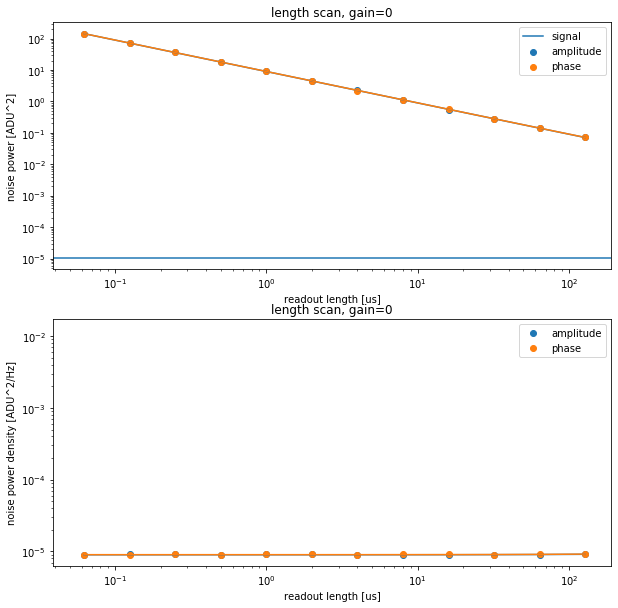

In [75]:
# terminator on ADC
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])
length_scan(0)

In [109]:
dbm_40db = -56.40 # from spectrum analyzer, pulse_gain 10000, attenuations 0+15 dB DAC + 40 dB external


adu2_40db = 4.26e+06 # from loopback, pulse_gain 10000, attenuations 0+15 dB DAC + 40 dB external + 30 dB ADC
adu2_per_hz = 8.98e-06 # from zero-power measurement, attenuations 30 dB ADC

w_per_adu2 = 1e-3*10**(dbm_40db/10)/adu2_40db
print("conversion factor (W per ADU^2): ", w_per_adu2)
k_B = 1.380649e-23
noiseT_total = adu2_per_hz*w_per_adu2/k_B
refT = 293
noiseT_added = noiseT_total - refT
noise_figure = 10*np.log10(noiseT_total/refT)
print("total noise temp %.2f K: %.2f K above 293 K reference level, noise figure %.2f dB"%
      (noiseT_total, noiseT_added, noise_figure))

conversion factor (W per ADU^2):  5.37762359804642e-16
total noise temp 349.77 K: 56.77 K above 293 K reference level, noise figure 0.77 dB


### high high-side LO

In [79]:
rfb_cfg={
#         "f_lo_ro":122.88*59, # 7249.92 - better SNR
        "f_lo_ro":122.88*65, # 7987.20 - less LO leakage
#          "f_lo_qubit":122.88*28,
        "att_res":(0,10),
#         "att_qubit":(0,16),
         "att_ro":30
       }
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0, verbose=True) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
# soc.rfb_set_gen_rf(gen_ch=hw_cfg['qubit_ch'], att1=rfb_cfg['att_qubit'][0], att2=rfb_cfg['att_qubit'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

meas_cfg={"pulse_gain":10000,
    "if_res": abs(soc.rfb_get_lo(gen_ch=hw_cfg['res_ch']) - hw_cfg['f_res']), # MHz, start value
#     "if_ge": abs(soc.rfb_get_lo(gen_ch=hw_cfg['qubit_ch']) - hw_cfg['f_ge']), # MHz, start value
    "nqz":1,
    'adc_trig_offset': 0.42,
    'length': 10,
    'readout_padding': -0.1,
    'relax_delay': 1
       }

# print("qubit IF=%f, readout IF=%f"%(meas_cfg['if_ge'], meas_cfg['if_res']))
print("readout IF=%f"%(meas_cfg['if_res']))

  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 |  7987.20 |   1 |       1 |   65 |  False |    1 |    1 |     1 |  122.88 |  7987.20 |    0.00 | 6.5000e+01

Choosing solution 0 with minimal metric 65.
LO locked on attempt 1 after 0.00 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 |  7987.20 |   1 |       1 |   65 |  False |    1 |    1 |     1 |  122.88 |  7987.20 |    0.00 | 6.5000e+01

Choosing solution 0 with minimal metric 65.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------

In [80]:
progconfig={
    'style': 'const',
    'length': 0.5,
    'reps': 1,
    'soft_avgs': 1
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs
prog = PeriodicProgram(soccfg, config)
# print(prog)
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

iq_list = prog.acquire_decimated(soc, progress=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Text(0, 0.5, 'amplitude [ADU]')

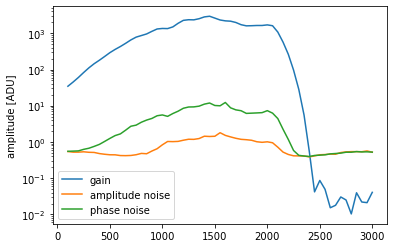

In [81]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 10, # [us]
    'reps': 1000
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs

freqs = np.arange(100, 3001, 50, dtype=float)
mags = np.zeros_like(freqs)
noises = np.zeros_like(freqs)
noise_phase = np.zeros_like(freqs)

for i, f in tqdm(list(enumerate(freqs))):
    config['if_res'] = f
    
    prog = SingleGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    
    d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
    
    dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
    mags[i] = dmag
    noises[i] = rmsmag
    noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags, label='gain')
plt.semilogy(freqs, noises, label='amplitude noise')
plt.semilogy(freqs, noise_phase, label='phase noise')
plt.legend()
plt.ylabel("amplitude [ADU]")


  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 8.78e+06 ADU^2, noise (mag, pha) (2.66e+02, 6.43e+02) ADU^2, (1.66e-05, 4.02e-05) ADU^2/Hz
  0.125 us: signal 8.78e+06 ADU^2, noise (mag, pha) (1.31e+02, 5.03e+02) ADU^2, (1.64e-05, 6.29e-05) ADU^2/Hz
  0.250 us: signal 8.78e+06 ADU^2, noise (mag, pha) (6.72e+01, 4.12e+02) ADU^2, (1.68e-05, 1.03e-04) ADU^2/Hz
  0.500 us: signal 8.79e+06 ADU^2, noise (mag, pha) (3.41e+01, 3.54e+02) ADU^2, (1.70e-05, 1.77e-04) ADU^2/Hz
  1.000 us: signal 8.79e+06 ADU^2, noise (mag, pha) (1.70e+01, 3.43e+02) ADU^2, (1.70e-05, 3.43e-04) ADU^2/Hz
  2.000 us: signal 8.79e+06 ADU^2, noise (mag, pha) (9.05e+00, 2.40e+02) ADU^2, (1.81e-05, 4.80e-04) ADU^2/Hz
  4.000 us: signal 8.79e+06 ADU^2, noise (mag, pha) (4.63e+00, 2.02e+02) ADU^2, (1.85e-05, 8.08e-04) ADU^2/Hz
  8.000 us: signal 8.79e+06 ADU^2, noise (mag, pha) (3.03e+00, 1.61e+02) ADU^2, (2.42e-05, 1.29e-03) ADU^2/Hz
 16.000 us: signal 8.79e+06 ADU^2, noise (mag, pha) (1.48e+00, 1.51e+02) ADU^2, (2.37e-05, 2.41e-03) ADU^2/Hz
 32.000 us

array([-2.27540084e-03,  1.82950811e-05])

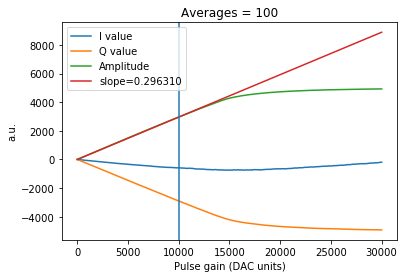

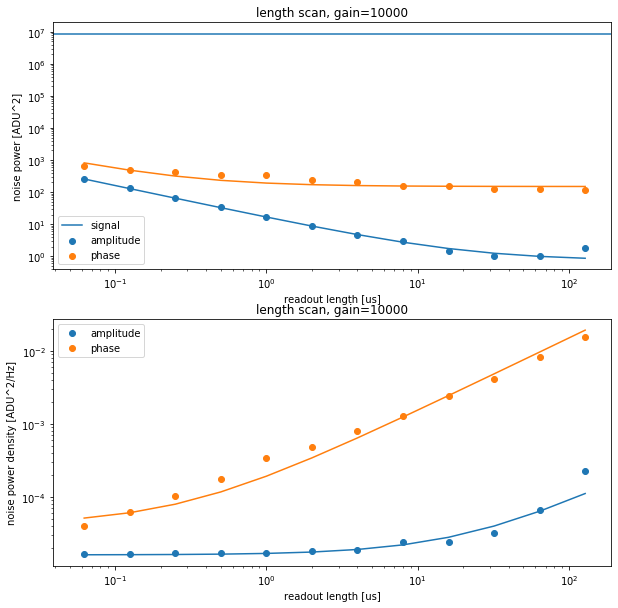

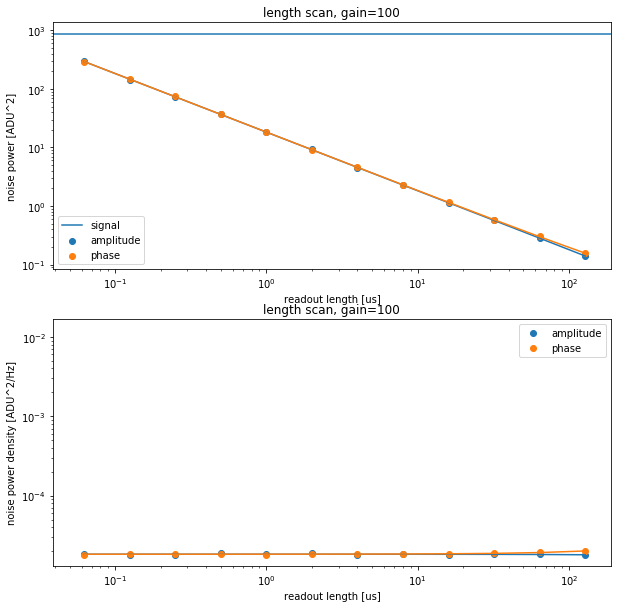

In [83]:
# loopback with 40 dB
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])
check_linearity(10000)
length_scan(10000)
length_scan(100)

  0.062 us: signal 2.35e-01 ADU^2, noise (mag, pha) (2.78e+02, 2.78e+02) ADU^2, (1.74e-05, 1.74e-05) ADU^2/Hz
  0.125 us: signal 3.86e-02 ADU^2, noise (mag, pha) (1.40e+02, 1.40e+02) ADU^2, (1.75e-05, 1.75e-05) ADU^2/Hz
  0.250 us: signal 1.86e-02 ADU^2, noise (mag, pha) (7.03e+01, 7.01e+01) ADU^2, (1.76e-05, 1.75e-05) ADU^2/Hz
  0.500 us: signal 1.04e-02 ADU^2, noise (mag, pha) (3.57e+01, 3.59e+01) ADU^2, (1.79e-05, 1.79e-05) ADU^2/Hz
  1.000 us: signal 6.97e-03 ADU^2, noise (mag, pha) (1.79e+01, 1.78e+01) ADU^2, (1.79e-05, 1.78e-05) ADU^2/Hz
  2.000 us: signal 1.70e-05 ADU^2, noise (mag, pha) (8.86e+00, 8.92e+00) ADU^2, (1.77e-05, 1.78e-05) ADU^2/Hz
  4.000 us: signal 1.56e-04 ADU^2, noise (mag, pha) (4.29e+00, 4.41e+00) ADU^2, (1.72e-05, 1.76e-05) ADU^2/Hz
  8.000 us: signal 2.44e-04 ADU^2, noise (mag, pha) (2.24e+00, 2.24e+00) ADU^2, (1.79e-05, 1.80e-05) ADU^2/Hz
 16.000 us: signal 8.36e-05 ADU^2, noise (mag, pha) (1.12e+00, 1.10e+00) ADU^2, (1.79e-05, 1.75e-05) ADU^2/Hz
 32.000 us

array([2.62098851e-03, 1.76183395e-05])

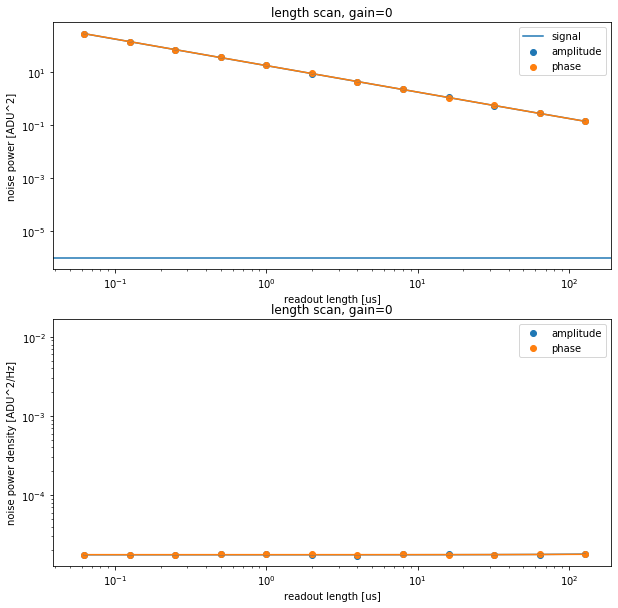

In [84]:
# terminator on ADC
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])
length_scan(0)

In [110]:
dbm_40db = -54.30 # from spectrum analyzer, pulse_gain 10000, attenuations 0+15 dB DAC + 40 dB external

adu2_40db = 8.78e+06 # from loopback, pulse_gain 10000, attenuations 0+15 dB DAC + 40 dB external + 30 dB ADC
adu2_per_hz = 1.76e-05 # from zero-power measurement, attenuations 30 dB ADC

w_per_adu2 = 1e-3*10**(dbm_40db/10)/adu2_40db
print("conversion factor (W per ADU^2): ", w_per_adu2)
k_B = 1.380649e-23
noiseT_total = adu2_per_hz*w_per_adu2/k_B
refT = 293
noiseT_added = noiseT_total - refT
noise_figure = 10*np.log10(noiseT_total/refT)
print("total noise temp %.2f K: %.2f K above 293 K reference level, noise figure %.2f dB"%
      (noiseT_total, noiseT_added, noise_figure))

conversion factor (W per ADU^2):  4.23160853185846e-16
total noise temp 539.43 K: 246.43 K above 293 K reference level, noise figure 2.65 dB


### low-side LO
This configuration is probably a bad idea for readout unless you use a highpass or bandpass filter to kill the lower sideband - otherwise, that sideband is effectively a second readout path. You may see weird oscillations in frequency sweeps (since you've basically built an interferometer), and resonator dips seen by one sideband will tend to be drowned out by the other sideband.

I haven't used any external filtering here.

In [95]:
rfb_cfg={
#         "f_lo_ro":122.88*59, # 7249.92 - better SNR
#         "f_lo_ro":122.88*65, # 7987.20 - less LO leakage
        "f_lo_ro":122.88*44, # 7987.20 - less LO leakage
#          "f_lo_qubit":122.88*28,
        "att_res":(0,25),
#         "att_qubit":(0,16),
         "att_ro":30
       }
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=0, verbose=True) # ADCs
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=1, verbose=True) # DACs 0-3
soc.rfb_set_lo(rfb_cfg['f_lo_ro'], ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
# soc.rfb_set_gen_rf(gen_ch=hw_cfg['qubit_ch'], att1=rfb_cfg['att_qubit'][0], att2=rfb_cfg['att_qubit'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

meas_cfg={"pulse_gain":10000,
    "if_res": abs(soc.rfb_get_lo(gen_ch=hw_cfg['res_ch']) - hw_cfg['f_res']), # MHz, start value
#     "if_ge": abs(soc.rfb_get_lo(gen_ch=hw_cfg['qubit_ch']) - hw_cfg['f_ge']), # MHz, start value
    "nqz":1,
    'adc_trig_offset': 0.42,
    'length': 10,
    'readout_padding': -0.1,
    'relax_delay': 1
       }

# print("qubit IF=%f, readout IF=%f"%(meas_cfg['if_ge'], meas_cfg['if_res']))
print("readout IF=%f"%(meas_cfg['if_res']))

  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 10813.44 |   2 |       1 |   88 |  False |    1 |    1 |     1 |  122.88 |  5406.72 |    0.00 | 1.7600e+02

Choosing solution 0 with minimal metric 176.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|------|--------|------|------|-------|---------|----------|---------|------------
  0 | 10813.44 |   2 |       1 |   88 |  False |    1 |    1 |     1 |  122.88 |  5406.72 |    0.00 | 1.7600e+02

Choosing solution 0 with minimal metric 176.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | DLY_SEL |   n  | osc_2x |   R  | mult | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|---------|----

In [103]:
progconfig={
    'style': 'const',
    'length': 0.5,
    'reps': 1,
    'soft_avgs': 1
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs
prog = PeriodicProgram(soccfg, config)
# print(prog)
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])

iq_list = prog.acquire_decimated(soc, progress=True)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Text(0, 0.5, 'amplitude [ADU]')

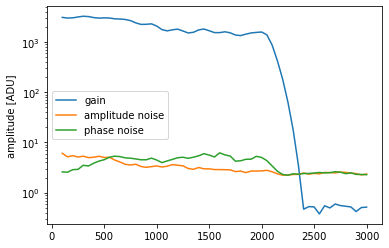

In [98]:
progconfig={
    'style': 'const',
#     'style': 'flat_top',
    'length': 10, # [us]
    'reps': 1000
       }
config={**hw_cfg,**meas_cfg,**progconfig} #combine configs

freqs = np.arange(100, 3001, 50, dtype=float)
mags = np.zeros_like(freqs)
noises = np.zeros_like(freqs)
noise_phase = np.zeros_like(freqs)

for i, f in tqdm(list(enumerate(freqs))):
    config['if_res'] = f
    
    prog = SingleGenLoopbackProgram(soccfg, config)
    res = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    
    d_buf = np.stack([prog.di_buf, prog.dq_buf], axis=-1)[0]/prog.ro_chs[0]['length']
    
    dmag, rmsmag, rmspha, magerr, phaerr = noise(d_buf, verbose=False)
    mags[i] = dmag
    noises[i] = rmsmag
    noise_phase[i] = rmspha
    
# plt.semilogy(soc.rfb_get_lo(gen_ch=config['res_ch']) - freqs, mags[:,0])
plt.semilogy(freqs, mags, label='gain')
plt.semilogy(freqs, noises, label='amplitude noise')
plt.semilogy(freqs, noise_phase, label='phase noise')
plt.legend()
plt.ylabel("amplitude [ADU]")


  0%|          | 0/30100 [00:00<?, ?it/s]

  0.062 us: signal 3.03e+06 ADU^2, noise (mag, pha) (1.16e+03, 1.18e+03) ADU^2, (7.24e-05, 7.38e-05) ADU^2/Hz
  0.125 us: signal 3.03e+06 ADU^2, noise (mag, pha) (5.68e+02, 6.25e+02) ADU^2, (7.11e-05, 7.82e-05) ADU^2/Hz
  0.250 us: signal 3.03e+06 ADU^2, noise (mag, pha) (3.07e+02, 3.35e+02) ADU^2, (7.67e-05, 8.37e-05) ADU^2/Hz
  0.500 us: signal 3.03e+06 ADU^2, noise (mag, pha) (1.56e+02, 1.88e+02) ADU^2, (7.78e-05, 9.42e-05) ADU^2/Hz
  1.000 us: signal 3.04e+06 ADU^2, noise (mag, pha) (8.41e+01, 1.04e+02) ADU^2, (8.41e-05, 1.04e-04) ADU^2/Hz
  2.000 us: signal 3.04e+06 ADU^2, noise (mag, pha) (4.57e+01, 6.33e+01) ADU^2, (9.15e-05, 1.27e-04) ADU^2/Hz
  4.000 us: signal 3.05e+06 ADU^2, noise (mag, pha) (2.53e+01, 3.82e+01) ADU^2, (1.01e-04, 1.53e-04) ADU^2/Hz
  8.000 us: signal 3.04e+06 ADU^2, noise (mag, pha) (1.56e+01, 2.64e+01) ADU^2, (1.25e-04, 2.11e-04) ADU^2/Hz
 16.000 us: signal 3.04e+06 ADU^2, noise (mag, pha) (9.40e+00, 1.92e+01) ADU^2, (1.50e-04, 3.06e-04) ADU^2/Hz
 32.000 us

array([5.84060786e-04, 7.44737116e-05])

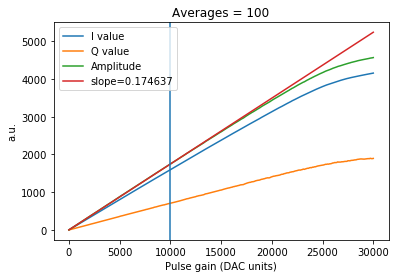

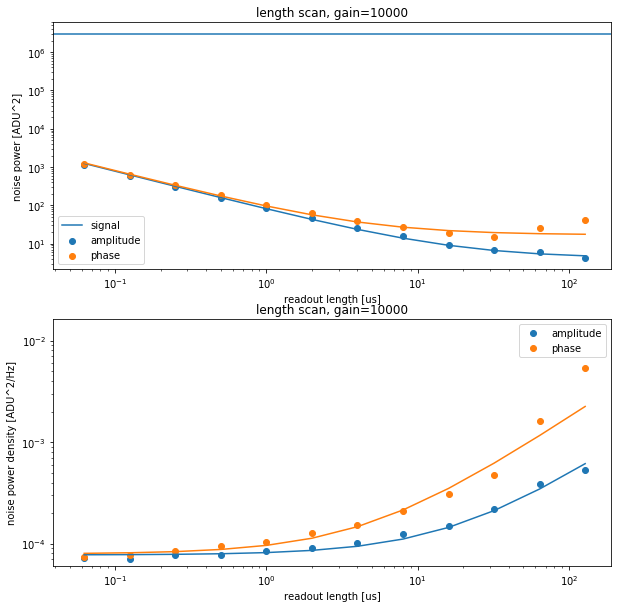

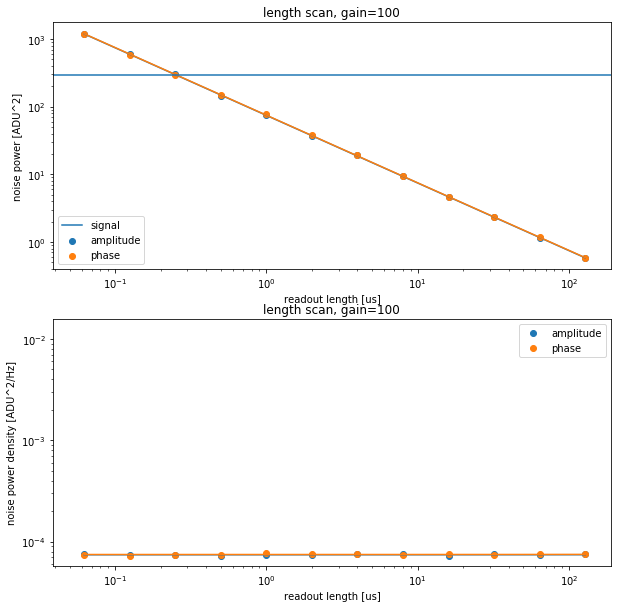

In [99]:
# loopback with 40 dB
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=rfb_cfg['att_res'][0], att2=rfb_cfg['att_res'][1])
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])
check_linearity(10000)
length_scan(10000)
length_scan(100)

  0.062 us: signal 1.05e-01 ADU^2, noise (mag, pha) (1.18e+03, 1.18e+03) ADU^2, (7.39e-05, 7.39e-05) ADU^2/Hz
  0.125 us: signal 4.98e-04 ADU^2, noise (mag, pha) (5.88e+02, 5.88e+02) ADU^2, (7.35e-05, 7.35e-05) ADU^2/Hz
  0.250 us: signal 2.87e-03 ADU^2, noise (mag, pha) (2.94e+02, 2.96e+02) ADU^2, (7.34e-05, 7.40e-05) ADU^2/Hz
  0.500 us: signal 1.86e-02 ADU^2, noise (mag, pha) (1.50e+02, 1.46e+02) ADU^2, (7.48e-05, 7.28e-05) ADU^2/Hz
  1.000 us: signal 2.12e-02 ADU^2, noise (mag, pha) (7.31e+01, 7.47e+01) ADU^2, (7.31e-05, 7.47e-05) ADU^2/Hz
  2.000 us: signal 3.40e-02 ADU^2, noise (mag, pha) (3.78e+01, 3.75e+01) ADU^2, (7.56e-05, 7.50e-05) ADU^2/Hz
  4.000 us: signal 1.00e-02 ADU^2, noise (mag, pha) (1.91e+01, 1.87e+01) ADU^2, (7.63e-05, 7.50e-05) ADU^2/Hz
  8.000 us: signal 4.95e-04 ADU^2, noise (mag, pha) (9.15e+00, 9.17e+00) ADU^2, (7.32e-05, 7.34e-05) ADU^2/Hz
 16.000 us: signal 1.85e-03 ADU^2, noise (mag, pha) (4.65e+00, 4.71e+00) ADU^2, (7.44e-05, 7.54e-05) ADU^2/Hz
 32.000 us

array([-1.13204726e-03,  7.42875268e-05])

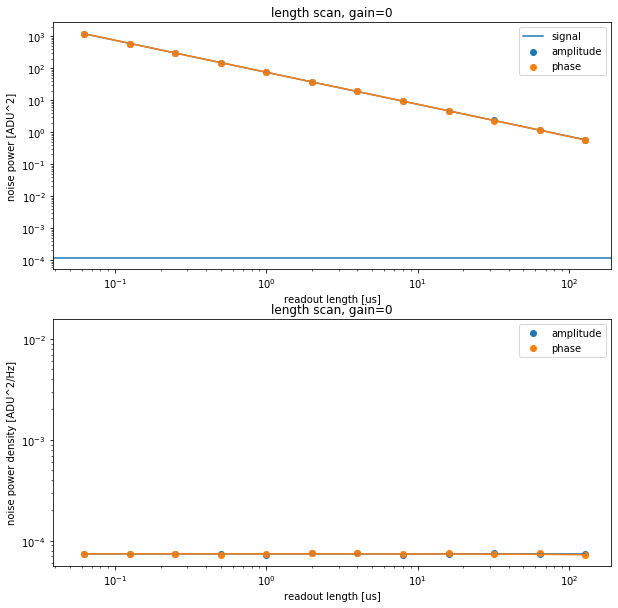

In [101]:
# terminator on ADC
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=rfb_cfg['att_ro'])
length_scan(0)

In [111]:
# from spectrum analyzer, pulse_gain 10000, attenuations 0+25 dB DAC + 40 dB external
# -66.13 at LO-RF
# -69.67 at LO+RF

# let's just add the two powers
dbm_40db = 10*np.log10(10**(-66.13/10)+10**(-69.67/10))

adu2_40db = 3.06e+06 # from loopback, pulse_gain 10000, attenuations 0+25 dB DAC + 40 dB external + 30 dB ADC
adu2_per_hz = 7.43e-05 # from zero-power measurement, attenuations 30 dB ADC

w_per_adu2 = 1e-3*10**(dbm_40db/10)/adu2_40db
print("conversion factor (W per ADU^2): ", w_per_adu2)
k_B = 1.380649e-23
noiseT_total = adu2_per_hz*w_per_adu2/k_B
refT = 293
noiseT_added = noiseT_total - refT
noise_figure = 10*np.log10(noiseT_total/refT)
print("total noise temp %.2f K: %.2f K above 293 K reference level, noise figure %.2f dB"%
      (noiseT_total, noiseT_added, noise_figure))

conversion factor (W per ADU^2):  1.1492671701302556e-16
total noise temp 618.48 K: 325.48 K above 293 K reference level, noise figure 3.24 dB


In [ ]:
#scratchwork below

In [ ]:
soc.rfb_set_gen_rf(gen_ch=hw_cfg['res_ch'], att1=0, att2=20)
soc.rfb_set_ro_rf(ro_ch=hw_cfg['ro_ch'], att=30)
check_linearity(500)
